# Imports and functions

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import timeit

In [3]:
citiesnp = np.genfromtxt('cities.csv', delimiter=',', skip_header = 1) # load as numpy array

In [4]:
def not_prime(n):
    if n == 2:
        return False
    if n % 2 == 0 or n <= 1:
        return True

    sqr = int(math.sqrt(n)) + 1

    for divisor in range(3, sqr, 2):
        if n % divisor == 0:
            return True
    return False

def is_prime(n):
    if n % 2 == 0 and n > 2: 
        return False
    return all(n % i for i in range(3, int(math.sqrt(n)) + 1, 2))

np_not_prime = np.vectorize(not_prime)

nums = np.arange(0,len(citiesnp))

not_primes_bool = np_not_prime(nums)

def np_total_length(r, c):
    # v8
    r = np.concatenate(([0], r))
    c = c[r, :]
    cs = np.roll(c, -1, axis =0)
    cid = cs[:,0].astype(int)
    d = np.sqrt((c[:,1] - cs[:,1])**2 + (c[:,2] - cs[:,2])**2)
    idx = np.arange(9, len(c), 10)
    pc = cid[idx]
    sel = (idx+1)[not_primes_bool[pc]]
    d[sel-1] *= 1.1
    
    return np.sum(d)

In [5]:
def route_fitness(r, c):
    return 1 / np_total_length(r, c)

In [6]:
np.random.seed(4)
idx = np.random.permutation(range(1, len(citiesnp)))

In [7]:
np_total_length(idx, citiesnp)

446925531.9322754

In [8]:
cities_sub = citiesnp[0:26]

In [9]:
np.random.seed(3)
idx = np.random.permutation(range(1,26))

In [10]:
np_total_length(idx, cities_sub)

60566.12398696876

# Genetic algorithm

### Generate Population

In [11]:
def pop_gen(n, pop_size):
    arr = np.repeat([np.arange(1, n)], pop_size, 0)
    return np.apply_along_axis(np.random.permutation, 1, arr)    

### Evaluate population

In [12]:
def pop_eval(array, pop, fit_fun):
    return np.apply_along_axis(fit_fun, 1, pop, c = array)

In [13]:
def pop_stats(scores):
    mean = np.mean(scores)
    med = np.median(scores)
    best = np.max(scores)
    return med, mean, best

### Selection

In [14]:
def roulette_selection(pop, scores, size):
    if size % 2 != 0:
        size += 1
    p = scores/np.sum(scores)
    sel = np.random.choice(len(pop), size, replace = True, p = p).reshape((size//2, 2))    
    return np.concatenate((pop[sel][:,0], pop[sel][:,1]), 1)

In [15]:
def roulette_selection2(pop, scores, size):
    if size % 2 != 0:
        size += 1
    p = scores/np.sum(scores)
    sel = np.random.choice(len(pop), size, replace = True, p = p).reshape((size//2, 2))
    return pop[sel]

### Crossover

In [16]:
def pairwise_crossover(p):
    n = len(p) // 2
    p0 = p[:n]
   
    p1 = p[n:]
    swath = np.random.randint(1, n)
    
    cut1 = np.random.randint(0, n - swath)
    cut2 = cut1 + swath
    
    off = np.repeat([0], n)
    
    sel = p0[cut1:cut2]
    off[cut1:cut2] = sel
    sel = p1[~np.isin(p1, sel)]
    off[0:cut1] = sel[0:cut1]

    off[cut2:] = sel[cut1:]
    return off   

In [17]:
def two_point_crossover(pa):
    return np.apply_along_axis(pairwise_crossover, 1, pa)

In [18]:
def two_point_crossover2(p):
    n = p.shape[2]
    swath = np.random.randint(1, n)
    
    cut1 = np.random.randint(0, n - swath)
    cut2 = cut1 + swath
    
    # print(cut1, cut2)
    
    ps0 = p.shape[0]
    off = np.zeros((ps0, n))
    
    sel = p[:, 0, cut1:cut2]
    off[:, cut1:cut2] = sel
    
    p1 = p[:, 1]
    sel = np.array(np.split(p1[~np.array([(np.isin(p1[i],sel[i])) for i in range(len(sel))])], ps0))
    
    off[:, 0:cut1] = sel[:, 0:cut1]
    off[:, cut2:] = sel[:, cut1:]
    return off   

In [19]:
def mod_two_point_crossover2(p):
    # http://www.rroij.com/open-access/enhanced-order-crossover-for-permutationproblems.php?aid=50178
    n = p.shape[2] 
    swath = np.random.randint(1, n // 7)
    
    cut1 = np.random.randint(0, n - swath)
    cut2 = cut1 + swath
    
    # print(cut1, cut2)
    
    ps0 = p.shape[0]
    off = np.zeros((ps0, n))
    
    sel = p[:, 0, cut1:cut2]
    off[:, cut1:cut2] = sel
    
    p1 = p[:, 1]
    sel = np.array(np.split(p1[~np.array([(np.isin(p1[i],sel[i])) for i in range(len(sel))])], ps0))
    
    off[:, 0:cut1] = sel[:, 0:cut1]
    off[:, cut2:] = sel[:, cut1:]
    return off   

In [20]:
def two_point_crossover3(p):
    n = p.shape[2]
    swath = np.random.randint(1, n)
    cut1 = np.random.randint(0, n - swath)
    cut2 = cut1 + swath
    ps0 = p.shape[0]
    
    off = np.zeros((ps0, n))
    sel = p[:, 0, cut1:cut2]
    off[:, cut1:cut2] = sel
    p1 = p[:, 1]
    
    result = np.empty_like(p1)
    for i in range(ps0):
        result[i] = ~np.isin(p1[i], sel[i])
    result = result.astype(bool)
    
    sel = np.array(np.split(p1[result], ps0))
    
    off[:, 0:cut1] = sel[:, 0:cut1]
    off[:, cut2:] = sel[:, cut1:]
    return off

### Mutation

In [21]:
def swap_mutation(perm):
    n = len(perm)
    i = np.random.choice(n, 2, replace = False)
    perm[i] = perm[i[::-1]]
    return perm    

In [22]:
def reverse_mutation(perm):
    n = len(perm) - 1
    i = np.random.choice(n, 1)[0]
    perm[i:i+2] = perm[i:i+2][::-1]
    return(perm)

In [23]:
def shift_mutation(perm):
    n = len(perm)
    i = np.random.choice(n, 2, replace = False)
    i = np.sort(i)
    i0 = i[0]
    i1 = i[1]
    perm = np.concatenate((perm[i1:], perm[i0:i1], perm[:i0][::-1]))
    return perm

In [24]:
# def centre_inverse_mutation(perm):
    

In [25]:
def pop_mutation(pop, mut_fun, mut_perc):
    sel = np.random.choice(len(pop), int(len(pop) * mut_perc), replace = False)
    pop[sel] = np.apply_along_axis(mut_fun, 1, pop[sel])
    return pop

### GA

In [27]:
def GA(array, n_gen, pop_size, parent_size, fit_fun, mut_funs, mut_perc, sel_fun,
       cross_fun = None, max_no_change = 100, verbose = False):
    n = len(array)
    
    # init pop
    pop = pop_gen(n, pop_size)
    
    scores = pop_eval(array, pop, fit_fun)
    med, mean, best = pop_stats(scores)
    
    ov_best = best # overall best score init
    best_pop = pop # overall best pop init
    med_trace = np.array([med]) # trace of median scores init
    mean_trace = np.array([mean]) # trace of mean scores init
    best_trace = np.array([best]) # trace of best scores init
    
    iter_no_change = 0
    i = 0
    
    while i < n_gen:
        # pass n_gen = np.inf to iterate until iter_no_change >= max_no_change
        
        # select best parents
        if verbose: start = datetime.now()
        parents = sel_fun(pop, scores, parent_size)
        if verbose:
            end = datetime.now()
            sel_sec = (end-start).total_seconds()
        
        if verbose: start = datetime.now()
        if not (cross_fun is None):
            ## no crossover
            ## j = np.random.choice(2)
            ## offs = parents[:, j]
            ## else:
            
            # generate offsprings
            offs = cross_fun(parents)   
        if verbose:
            end = datetime.now()
            gen_sec = (end-start).total_seconds()
        
        # replace worst in pop with offs
        if not (cross_fun is None):
            sort = np.argsort(scores)
            pop[sort[:len(offs)]] = offs
        
        # mutate pop
        if verbose: start = datetime.now()
        for fun in mut_funs:
            pop = pop_mutation(pop, fun, mut_perc)
        if verbose:
            end = datetime.now()
            mut_sec = (end-start).total_seconds()
        
        # evaluate
        if verbose: start = datetime.now()
        scores = pop_eval(array, pop, fit_fun)
        if verbose:
            end = datetime.now()
            ev_sec = (end-start).total_seconds()
        
        # update traces
        med, mean, best = pop_stats(scores) # new med, mean best scores
        
        if best > ov_best:
            ov_best = best
            best_pop = pop
            iter_no_change = 0
            
        med_trace = np.concatenate((med_trace, [med]))
        mean_trace = np.concatenate((mean_trace, [mean]))
        best_trace =  np.concatenate((best_trace, [best]))
        
        if verbose:
            if i % 10 == 0:
                text = [i, iter_no_change, sel_sec, gen_sec, mut_sec, ev_sec]
                text.append(sum(text[2:]))
                text.append(1/ov_best)
                print('Iter {}, ItNoChange {}, Sel {}, Cross {}, Mut {}, Ev {}, Tot {}, Best {}'.format(*text)) 
        
        i += 1
        iter_no_change += 1
        if iter_no_change >= max_no_change:
            break
        
    best_scores = pop_eval(array, best_pop, fit_fun)
    bpe = best_pop[np.argmax(best_scores)]
    

    
    return med_trace, mean_trace, best_trace, ov_best, bpe

In [28]:
def plot_GA(a, b, c, n):
    fig, ax = plt.subplots(figsize=(10,6))

    x = np.arange(0, len(c), n)
    l1 = ax.plot(x, a[::n])[0]
    l2 = ax.plot(x, b[::n])[0]
    l3 = ax.plot(x, c[::n])[0]
    
    line_labels = ["Median", "Average", "Best"]
    
    fig.legend([l1, l2, l3], line_labels, bbox_to_anchor=(0.7, 0.3))
    
    plt.show()

### Testing

In [47]:
np.random.seed(4)
a1, b1, c1, d1, e1 = GA(cities_sub, np.inf, 20, 10, route_fitness, [reverse_mutation], 0.3,
                        roulette_selection2, two_point_crossover2, verbose = 0)

1.8717114085183212e-05 1.8717114085183212e-05
1.9117315222361838e-05 1.9117315222361838e-05
1.978371503232663e-05 1.978371503232663e-05
2.1976905576670354e-05 2.1976905576670354e-05
2.2309245108937103e-05 2.2309245108937103e-05
2.2633227899236925e-05 2.2633227899236925e-05
2.299967871867099e-05 2.299967871867099e-05
2.324714789759895e-05 2.324714789759895e-05
2.3369728983355735e-05 2.3369728983355735e-05
2.3771384211134347e-05 2.3771384211134347e-05
2.5331859866897647e-05 2.5331859866897647e-05
2.5787654868240912e-05 2.5787654868240912e-05
2.607920522875884e-05 2.607920522875884e-05
2.6355328452744848e-05 2.6355328452744848e-05
2.6738808544323776e-05 2.6738808544323776e-05
2.706517329466235e-05 2.706517329466235e-05
2.8001076299342466e-05 2.8001076299342466e-05
2.830250161253001e-05 2.830250161253001e-05
2.8367513465868302e-05 2.8367513465868302e-05
2.9890197580171042e-05 2.9890197580171042e-05
2.991320911280766e-05 2.991320911280766e-05
2.994717581382184e-05 2.994717581382184e-05
3.06

In [48]:
e1

array([ 5, 15, 20,  3, 25,  9,  1,  7, 24, 12, 18,  4,  6,  8, 14, 13, 11,
       19, 21, 16, 17, 23,  2, 22, 10])

In [43]:
c1[-1], d1 #tour length of best route

(3.6472859483646505e-05, 3.669779310388559e-05)

In [44]:
route_fitness(e1, cities_sub)

3.6472859483646505e-05

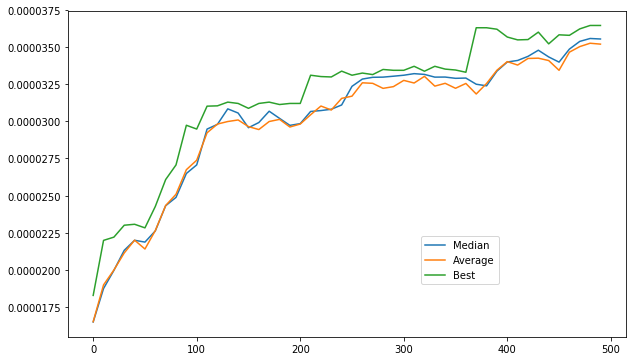

In [59]:
plot_GA(a1, b1, c1, 10)

In [ ]:
np.random.seed(4)
a1, b1, c1, d1, e1 = GA(cities_sub, np.inf, 20, 20, route_fitness, [reverse_mutation], 0.5,
                    roulette_selection2,  max_no_change = 1000)

In [ ]:
1/c1[-1], 1/d1 #tour length of best route

In [ ]:
plot_GA(a1, b1, c1, 10)

In [ ]:
np.random.seed(4)
a1, b1, c1, d1, e1 = GA(cities_sub, np.inf, 20, 20, route_fitness, [reverse_mutation, swap_mutation], 0.3,
                    roulette_selection2, cross_fun=mod_two_point_crossover2, max_no_change = 1000)

In [ ]:
1/c1[-1], 1/d1 #tour length of best route

In [ ]:
plot_GA(a1, b1, c1, 10)

In [ ]:
np.random.seed(4)
a1, b1, c1, d1, e1 = GA(cities_sub, np.inf, 20, 20, route_fitness, [shift_mutation], 0.1,
                    roulette_selection2, cross_fun=mod_two_point_crossover2, max_no_change = 1000)

In [ ]:
1/c1[-1], 1/d1 #tour length of best route

In [ ]:
plot_GA(a1, b1, c1, 10)

In [ ]:
np.random.seed(4)
a1, b1, c1, d1, e1 = GA(cities_sub, np.inf, 20, 10, route_fitness, [shift_mutation], 0.1,
                    roulette_selection2, cross_fun=mod_two_point_crossover2, max_no_change = 1000)

In [ ]:
1/c1[-1], 1/d1 #tour length of best route

In [ ]:
plot_GA(a1, b1, c1, 10)

## 1000 points

In [30]:
citiesnp

array([[0.00000000e+00, 3.16836739e+02, 2.20234071e+03],
       [1.00000000e+00, 4.37740597e+03, 3.36602082e+02],
       [2.00000000e+00, 3.45415820e+03, 2.82005301e+03],
       ...,
       [1.97766000e+05, 4.77588987e+03, 3.10384623e+03],
       [1.97767000e+05, 2.99423095e+03, 1.93176434e+03],
       [1.97768000e+05, 1.35476478e+03, 3.21810063e+03]])

In [31]:
cities_1000 = citiesnp[:1000]

In [36]:
np.random.seed(4)
a2, b2, c2, d2, e2 = GA(cities_1000, np.inf, 20, 6, route_fitness, [shift_mutation], 0.1,
                    roulette_selection2, cross_fun=mod_two_point_crossover2, max_no_change = 500, verbose = True)

Iter 0, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.003998, Up 0.0, Tot 0.003998, Best 2207641.463078468
Iter 10, Sel 0.0, Cross 0.004002, Rep 0.0, Mut 0.0, Ev 0.0, Up 0.0, Tot 0.004002, Best 2192424.175372451
Iter 20, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.004031, Up 0.0, Tot 0.004031, Best 2168636.9998015156
Iter 30, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.0, Up 0.0, Tot 0.0, Best 2165317.957340095
Iter 40, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.0, Up 0.0, Tot 0.004, Best 2157533.1761325304
Iter 50, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.0, Up 0.0, Tot 0.0, Best 2151264.014187013
Iter 60, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.0, Up 0.0, Tot 0.0, Best 2137235.5515565737
Iter 70, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.003999, Up 0.0, Tot 0.003999, Best 2130879.443956162
Iter 80, Sel 0.003992, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.003998, Up 0.0, Tot 0.00799, Best 2130879.443956162
Iter 90, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.004001, Up 0.0, Tot 0.004001, Bes

Iter 830, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.004061, Up 0.0, Tot 0.004061, Best 1810620.3158155717
Iter 840, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.0, Up 0.0, Tot 0.0, Best 1803024.373806567
Iter 850, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.004, Up 0.0, Tot 0.004, Best 1799283.9544392186
Iter 860, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.003997, Up 0.0, Tot 0.003997, Best 1795723.0515553341
Iter 870, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.003999, Up 0.0, Tot 0.003999, Best 1795723.0515553341
Iter 880, Sel 0.0, Cross 0.004004, Rep 0.0, Mut 0.0, Ev 0.0, Up 0.0, Tot 0.004004, Best 1791954.7735052188
Iter 890, Sel 0.0, Cross 0.004004, Rep 0.0, Mut 0.0, Ev 0.0, Up 0.0, Tot 0.004004, Best 1791954.7735052188
Iter 900, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.0, Up 0.0, Tot 0.0, Best 1791311.6903948376
Iter 910, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.0, Up 0.0, Tot 0.0, Best 1784806.6030673177
Iter 920, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.004, Up 0.0, Tot 0.00

Iter 1650, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.003971, Up 0.0, Tot 0.003971, Best 1593633.0294376737
Iter 1660, Sel 0.0, Cross 0.004045, Rep 0.0, Mut 0.0, Ev 0.0, Up 0.0, Tot 0.004045, Best 1593633.0294376737
Iter 1670, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.0, Up 0.0, Tot 0.0, Best 1593633.0294376737
Iter 1680, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.003999, Up 0.0, Tot 0.003999, Best 1593633.0294376737
Iter 1690, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.0, Up 0.0, Tot 0.0, Best 1590723.8968921446
Iter 1700, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.003999, Ev 0.0, Up 0.0, Tot 0.003999, Best 1588187.065934183
Iter 1710, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.004004, Up 0.0, Tot 0.004004, Best 1588187.065934183
Iter 1720, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.003998, Up 0.0, Tot 0.003998, Best 1587981.5767057193
Iter 1730, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.0, Up 0.004, Tot 0.004, Best 1583385.3494657688
Iter 1740, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.00

Iter 2460, Sel 0.004039, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.004016, Up 0.0, Tot 0.008055, Best 1464211.6309927353
Iter 2470, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.0, Up 0.0, Tot 0.0, Best 1459812.0214860965
Iter 2480, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.004, Up 0.0, Tot 0.004, Best 1458814.5445630937
Iter 2490, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.003997, Up 0.0, Tot 0.003997, Best 1458814.5445630937
Iter 2500, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.003969, Ev 0.0, Up 0.0, Tot 0.003969, Best 1457532.9185368903
Iter 2510, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.0, Up 0.0, Tot 0.004, Best 1457350.7292115989
Iter 2520, Sel 0.004004, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.0, Up 0.0, Tot 0.004004, Best 1447503.517251385
Iter 2530, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.0, Up 0.0, Tot 0.0, Best 1447503.517251385
Iter 2540, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.003961, Up 0.0, Tot 0.003961, Best 1444660.6613871437
Iter 2550, Sel 0.004, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.0

Iter 3290, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.004031, Up 0.0, Tot 0.004031, Best 1384735.7525057935
Iter 3300, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.004, Up 0.0, Tot 0.004, Best 1384735.7525057935
Iter 3310, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.003998, Ev 0.0, Up 0.0, Tot 0.003998, Best 1384735.7525057935
Iter 3320, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.0, Up 0.0, Tot 0.004, Best 1384735.7525057935
Iter 3330, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.0, Up 0.0, Tot 0.004, Best 1384735.7525057935
Iter 3340, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.0, Up 0.0, Tot 0.0, Best 1384735.7525057935
Iter 3350, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.0, Up 0.0, Tot 0.0, Best 1384735.7525057935
Iter 3360, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.004, Up 0.0, Tot 0.004, Best 1384735.7525057935
Iter 3370, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.003998, Up 0.0, Tot 0.003998, Best 1384735.7525057935
Iter 3380, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.00403, Up 0.0, Tot

Iter 4120, Sel 0.0, Cross 0.004009, Rep 0.0, Mut 0.0, Ev 0.0, Up 0.0, Tot 0.004009, Best 1334466.6292438298
Iter 4130, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.003972, Up 0.0, Tot 0.003972, Best 1334086.790113329
Iter 4140, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.0, Up 0.0, Tot 0.0, Best 1330904.9207859505
Iter 4150, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.004001, Up 0.0, Tot 0.004001, Best 1329804.0414048247
Iter 4160, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.004, Up 0.0, Tot 0.004, Best 1329804.0414048247
Iter 4170, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.004, Ev 0.0, Up 0.0, Tot 0.004, Best 1329804.0414048247
Iter 4180, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.0, Up 0.0, Tot 0.004, Best 1327716.3870363715
Iter 4190, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.0, Up 0.0, Tot 0.0, Best 1327716.3870363715
Iter 4200, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.003995, Ev 0.0, Up 0.0, Tot 0.003995, Best 1327716.3870363715
Iter 4210, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.003999, Up 0.

Iter 4980, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.004041, Ev 0.0, Up 0.003961, Tot 0.008002, Best 1280951.7232173355
Iter 4990, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.004, Up 0.0, Tot 0.004, Best 1280951.7232173355
Iter 5000, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.004, Ev 0.004001, Up 0.0, Tot 0.008001000000000001, Best 1280951.7232173355
Iter 5010, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.004, Up 0.0, Tot 0.004, Best 1280951.7232173355
Iter 5020, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.004, Up 0.0, Tot 0.004, Best 1280951.7232173355
Iter 5030, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.0, Up 0.0, Tot 0.0, Best 1280951.7232173355
Iter 5040, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.0, Up 0.0, Tot 0.0, Best 1280951.7232173355
Iter 5050, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.004, Up 0.0, Tot 0.004, Best 1280951.7232173355
Iter 5060, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.003997, Ev 0.0, Up 0.0, Tot 0.003997, Best 1280951.7232173355
Iter 5070, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0

Iter 5790, Sel 0.004043, Cross 0.0, Rep 0.0, Mut 0.003966, Ev 0.003988, Up 0.0, Tot 0.011996999999999999, Best 1248156.8686162585
Iter 5800, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.00399, Up 0.0, Tot 0.00399, Best 1248156.8686162585
Iter 5810, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.003991, Ev 0.0, Up 0.0, Tot 0.003991, Best 1248156.8686162585
Iter 5820, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.003974, Up 0.0, Tot 0.003974, Best 1248156.8686162585
Iter 5830, Sel 0.0, Cross 0.004047, Rep 0.0, Mut 0.003968, Ev 0.003985, Up 0.0, Tot 0.012, Best 1248156.8686162585
Iter 5840, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.004, Up 0.0, Tot 0.004, Best 1248156.8686162585
Iter 5850, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.003999, Up 0.0, Tot 0.003999, Best 1248156.8686162585
Iter 5860, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.004001, Up 0.0, Tot 0.004001, Best 1248156.8686162585
Iter 5870, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.0, Up 0.0, Tot 0.0, Best 1248156.8686162585
Iter 5880, Sel 0.

In [37]:
1/c2[-1], 1/d2 #tour length of best route

(1249040.0510588775, 1246956.1413175082)

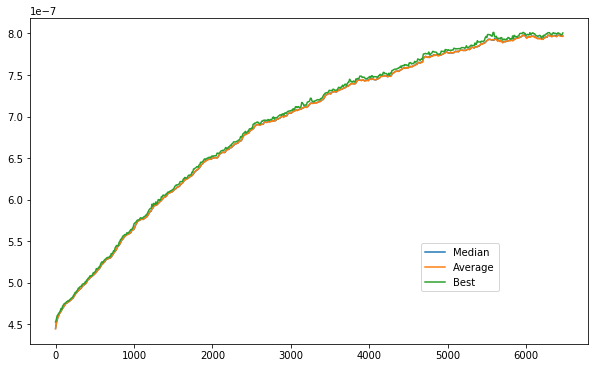

In [38]:
plot_GA(a2, b2, c2, 10)

## 10k points

In [40]:
cities_10k = citiesnp[:10000]

In [44]:
np.random.seed(4)
a2, b2, c2, d2, e2 = GA(cities_10k, np.inf, 20, 6, route_fitness, [shift_mutation], 0.1,
                    roulette_selection2, cross_fun=mod_two_point_crossover2, max_no_change = 500, verbose = True)

Iter 0, Sel 0.0, Cross 0.004003, Rep 0.0, Mut 0.003997, Ev 0.007999, Up 0.0, Tot 0.015999, Best 22230216.092513934
Iter 10, Sel 0.004, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.008001, Up 0.0, Tot 0.012001, Best 22037908.04356378
Iter 20, Sel 0.0, Cross 0.003962, Rep 0.0, Mut 0.003993, Ev 0.007999, Up 0.0, Tot 0.015954, Best 22037908.04356378
Iter 30, Sel 0.0, Cross 0.003997, Rep 0.0, Mut 0.0, Ev 0.008002, Up 0.0, Tot 0.011999, Best 22019798.721767448
Iter 40, Sel 0.0, Cross 0.003999, Rep 0.0, Mut 0.0, Ev 0.008, Up 0.0, Tot 0.011999, Best 21976726.870342515
Iter 50, Sel 0.0, Cross 0.003999, Rep 0.0, Mut 0.0, Ev 0.008001, Up 0.0, Tot 0.012, Best 21888430.77659203
Iter 60, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.007997, Up 0.0, Tot 0.011997, Best 21878021.026138872
Iter 70, Sel 0.0, Cross 0.004002, Rep 0.0, Mut 0.0, Ev 0.003997, Up 0.004023, Tot 0.012021999999999998, Best 21870914.49541761
Iter 80, Sel 0.0, Cross 0.004005, Rep 0.0, Mut 0.003994, Ev 0.008, Up 0.0, Tot 0.015999, Best 21863016

Iter 730, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.007998, Up 0.0, Tot 0.011998, Best 21483334.556887753
Iter 740, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.007999, Up 0.0, Tot 0.011999, Best 21472086.878680065
Iter 750, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.008, Up 0.0, Tot 0.008, Best 21462526.83739829
Iter 760, Sel 0.0, Cross 0.003998, Rep 0.0, Mut 0.0, Ev 0.008003, Up 0.0, Tot 0.012001, Best 21459169.70313903
Iter 770, Sel 0.0, Cross 0.007989, Rep 0.0, Mut 0.0, Ev 0.012021, Up 0.0, Tot 0.02001, Best 21456535.040308997
Iter 780, Sel 0.0, Cross 0.003998, Rep 0.0, Mut 0.0, Ev 0.004001, Up 0.0, Tot 0.007999, Best 21451094.86253622
Iter 790, Sel 0.0, Cross 0.004018, Rep 0.0, Mut 0.003988, Ev 0.007993, Up 0.0, Tot 0.015999, Best 21440060.106992114
Iter 800, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.004022, Ev 0.003999, Up 0.0, Tot 0.008021, Best 21425388.024708036
Iter 810, Sel 0.0, Cross 0.008001, Rep 0.0, Mut 0.0, Ev 0.008, Up 0.0, Tot 0.016001, Best 21423096.659408115
Iter 820, S

Iter 1470, Sel 0.0, Cross 0.003997, Rep 0.0, Mut 0.0, Ev 0.004, Up 0.0, Tot 0.007997, Best 21073292.46873762
Iter 1480, Sel 0.0, Cross 0.003988, Rep 0.0, Mut 0.0, Ev 0.008001, Up 0.0, Tot 0.011989, Best 21073292.46873762
Iter 1490, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.004013, Ev 0.016015, Up 0.0, Tot 0.024028, Best 21066217.77132929
Iter 1500, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.008002, Up 0.0, Tot 0.012002, Best 21056610.770452052
Iter 1510, Sel 0.0, Cross 0.004003, Rep 0.0, Mut 0.0, Ev 0.008, Up 0.0, Tot 0.012003, Best 21051109.784290317
Iter 1520, Sel 0.0, Cross 0.004001, Rep 0.0, Mut 0.0, Ev 0.008004, Up 0.0, Tot 0.012005000000000002, Best 21047158.53442229
Iter 1530, Sel 0.0, Cross 0.003983, Rep 0.0, Mut 0.0, Ev 0.016074, Up 0.0, Tot 0.020057000000000002, Best 21037559.679611564
Iter 1540, Sel 0.0, Cross 0.00801, Rep 0.0, Mut 0.0, Ev 0.01199, Up 0.0, Tot 0.02, Best 21023051.719988845
Iter 1550, Sel 0.0, Cross 0.004009, Rep 0.0, Mut 0.0, Ev 0.007991, Up 0.0, Tot 0.012, Bes

Iter 2210, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.003999, Ev 0.016037, Up 0.0, Tot 0.020035999999999998, Best 20671246.44483463
Iter 2220, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.004, Ev 0.004001, Up 0.0, Tot 0.008001000000000001, Best 20666262.0738645
Iter 2230, Sel 0.0, Cross 0.004002, Rep 0.0, Mut 0.0, Ev 0.007999, Up 0.0, Tot 0.012001, Best 20653207.869109884
Iter 2240, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.004002, Ev 0.003998, Up 0.0, Tot 0.008, Best 20647977.674797647
Iter 2250, Sel 0.0, Cross 0.004002, Rep 0.0, Mut 0.0, Ev 0.007994, Up 0.0, Tot 0.011996, Best 20640060.647191614
Iter 2260, Sel 0.0, Cross 0.003996, Rep 0.0, Mut 0.0, Ev 0.008001, Up 0.0, Tot 0.011997, Best 20640060.647191614
Iter 2270, Sel 0.0, Cross 0.004001, Rep 0.0, Mut 0.0, Ev 0.007999, Up 0.0, Tot 0.012, Best 20630408.957142055
Iter 2280, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.008, Up 0.0, Tot 0.012, Best 20619692.40743371
Iter 2290, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.016, Up 0.0, Tot 0.02, Best 20619262.1

Iter 2950, Sel 0.0, Cross 0.008025, Rep 0.0, Mut 0.0, Ev 0.007973, Up 0.0, Tot 0.015998, Best 20337518.624564223
Iter 2960, Sel 0.0, Cross 0.004004, Rep 0.0, Mut 0.0, Ev 0.007996, Up 0.0, Tot 0.012, Best 20336775.982234966
Iter 2970, Sel 0.0, Cross 0.008003, Rep 0.0, Mut 0.0, Ev 0.011996, Up 0.0, Tot 0.019999, Best 20322145.71308076
Iter 2980, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.004, Ev 0.004007, Up 0.0, Tot 0.008007, Best 20320517.609641984
Iter 2990, Sel 0.0, Cross 0.004001, Rep 0.0, Mut 0.0, Ev 0.008002, Up 0.0, Tot 0.012003, Best 20319176.77439079
Iter 3000, Sel 0.0, Cross 0.003994, Rep 0.0, Mut 0.0, Ev 0.008008, Up 0.0, Tot 0.012001999999999999, Best 20314777.90729583
Iter 3010, Sel 0.0, Cross 0.003999, Rep 0.0, Mut 0.0, Ev 0.008, Up 0.0, Tot 0.011999, Best 20313259.532727625
Iter 3020, Sel 0.0, Cross 0.004007, Rep 0.0, Mut 0.0, Ev 0.007997, Up 0.0, Tot 0.012004, Best 20294703.49746382
Iter 3030, Sel 0.0, Cross 0.004017, Rep 0.0, Mut 0.003983, Ev 0.008005, Up 0.0, Tot 0.016005, Bes

Iter 3690, Sel 0.0, Cross 0.003999, Rep 0.0, Mut 0.0, Ev 0.008001, Up 0.0, Tot 0.012, Best 19991764.762022335
Iter 3700, Sel 0.0, Cross 0.003997, Rep 0.0, Mut 0.0, Ev 0.008007, Up 0.0, Tot 0.012004, Best 19991764.762022335
Iter 3710, Sel 0.0, Cross 0.00803, Rep 0.0, Mut 0.0, Ev 0.00797, Up 0.0, Tot 0.016, Best 19983699.910575993
Iter 3720, Sel 0.0, Cross 0.003997, Rep 0.0, Mut 0.0, Ev 0.008, Up 0.0, Tot 0.011997, Best 19983699.910575993
Iter 3730, Sel 0.0, Cross 0.003999, Rep 0.0, Mut 0.0, Ev 0.008, Up 0.0, Tot 0.011999, Best 19973622.543031815
Iter 3740, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.007999, Up 0.0, Tot 0.011999, Best 19971742.285886444
Iter 3750, Sel 0.0, Cross 0.008044, Rep 0.0, Mut 0.0, Ev 0.007954, Up 0.0, Tot 0.015998, Best 19971742.285886444
Iter 3760, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.007999, Up 0.0, Tot 0.011999, Best 19971742.285886444
Iter 3770, Sel 0.0, Cross 0.004003, Rep 0.0, Mut 0.0, Ev 0.007999, Up 0.0, Tot 0.012001999999999999, Best 19964537.7

Iter 4420, Sel 0.0, Cross 0.012029, Rep 0.0, Mut 0.0, Ev 0.020008, Up 0.0, Tot 0.032037, Best 19723583.014184482
Iter 4430, Sel 0.0, Cross 0.004001, Rep 0.0, Mut 0.0, Ev 0.008003, Up 0.0, Tot 0.012004, Best 19722524.218962714
Iter 4440, Sel 0.0, Cross 0.003998, Rep 0.0, Mut 0.0, Ev 0.008, Up 0.0, Tot 0.011998, Best 19710607.70317458
Iter 4450, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.004, Ev 0.003999, Up 0.0, Tot 0.007999, Best 19700386.151566945
Iter 4460, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.004004, Ev 0.003998, Up 0.0, Tot 0.008001999999999999, Best 19700386.151566945
Iter 4470, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.012001, Up 0.0, Tot 0.016001, Best 19700386.151566945
Iter 4480, Sel 0.0, Cross 0.008007, Rep 0.0, Mut 0.004029, Ev 0.027965, Up 0.0, Tot 0.040001, Best 19700386.151566945
Iter 4490, Sel 0.0, Cross 0.007967, Rep 0.0, Mut 0.0, Ev 0.028005, Up 0.003995, Tot 0.039966999999999996, Best 19693369.263754763
Iter 4500, Sel 0.0, Cross 0.008, Rep 0.0, Mut 0.0, Ev 0.02, Up 0.0, Tot 

Iter 5150, Sel 0.004029, Cross 0.004058, Rep 0.0, Mut 0.0, Ev 0.032015, Up 0.0, Tot 0.040102, Best 19440580.55578325
Iter 5160, Sel 0.0, Cross 0.004011, Rep 0.0, Mut 0.0, Ev 0.012009, Up 0.0, Tot 0.01602, Best 19439865.505530983
Iter 5170, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.003986, Ev 0.004028, Up 0.0, Tot 0.008014, Best 19432251.724769276
Iter 5180, Sel 0.0, Cross 0.003994, Rep 0.0, Mut 0.0, Ev 0.008005, Up 0.0, Tot 0.011999, Best 19429854.196484298
Iter 5190, Sel 0.0, Cross 0.004001, Rep 0.0, Mut 0.0, Ev 0.007999, Up 0.0, Tot 0.012, Best 19423140.306971863
Iter 5200, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.004, Ev 0.004002, Up 0.0, Tot 0.008002, Best 19419821.25054602
Iter 5210, Sel 0.0, Cross 0.003999, Rep 0.0, Mut 0.0, Ev 0.008, Up 0.0, Tot 0.011999, Best 19419821.25054602
Iter 5220, Sel 0.0, Cross 0.003999, Rep 0.0, Mut 0.0, Ev 0.008, Up 0.0, Tot 0.011999, Best 19412760.027501836
Iter 5230, Sel 0.0, Cross 0.008013, Rep 0.0, Mut 0.0, Ev 0.007992, Up 0.003993, Tot 0.019998, Best 19408679

Iter 5880, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.008001, Up 0.0, Tot 0.012001, Best 19168481.47720073
Iter 5890, Sel 0.0, Cross 0.004001, Rep 0.0, Mut 0.0, Ev 0.008, Up 0.0, Tot 0.012001000000000001, Best 19166730.257705413
Iter 5900, Sel 0.0, Cross 0.008008, Rep 0.0, Mut 0.0, Ev 0.00799, Up 0.003999, Tot 0.019996999999999997, Best 19141227.97318252
Iter 5910, Sel 0.0, Cross 0.004004, Rep 0.0, Mut 0.0, Ev 0.003996, Up 0.004, Tot 0.012, Best 19141227.97318252
Iter 5920, Sel 0.0, Cross 0.003967, Rep 0.0, Mut 0.004073, Ev 0.007926, Up 0.0, Tot 0.015966, Best 19141227.97318252
Iter 5930, Sel 0.003992, Cross 0.0, Rep 0.004005, Mut 0.0, Ev 0.020045, Up 0.0, Tot 0.028042, Best 19141227.97318252
Iter 5940, Sel 0.0, Cross 0.003993, Rep 0.0, Mut 0.0, Ev 0.008, Up 0.0, Tot 0.011993, Best 19132685.314283073
Iter 5950, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.008, Up 0.0, Tot 0.012, Best 19131395.11107559
Iter 5960, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.004006, Up 0.0, Tot 0.004006,

Iter 6620, Sel 0.0, Cross 0.003996, Rep 0.0, Mut 0.0, Ev 0.008, Up 0.0, Tot 0.011996, Best 18875453.473126836
Iter 6630, Sel 0.0, Cross 0.003999, Rep 0.0, Mut 0.0, Ev 0.023998, Up 0.0, Tot 0.027996999999999998, Best 18870985.832292035
Iter 6640, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.004, Ev 0.004, Up 0.0, Tot 0.012, Best 18861981.909335755
Iter 6650, Sel 0.0, Cross 0.004017, Rep 0.0, Mut 0.0, Ev 0.015984, Up 0.0, Tot 0.020001, Best 18853227.501224443
Iter 6660, Sel 0.0, Cross 0.004001, Rep 0.0, Mut 0.004005, Ev 0.028012, Up 0.0, Tot 0.036017999999999994, Best 18852887.276751243
Iter 6670, Sel 0.0, Cross 0.004003, Rep 0.0, Mut 0.0, Ev 0.007997, Up 0.0, Tot 0.012, Best 18852887.276751243
Iter 6680, Sel 0.0, Cross 0.008037, Rep 0.0, Mut 0.0, Ev 0.007963, Up 0.004, Tot 0.02, Best 18850997.403733693
Iter 6690, Sel 0.0, Cross 0.004007, Rep 0.0, Mut 0.0, Ev 0.007994, Up 0.0, Tot 0.012001, Best 18848167.046922304
Iter 6700, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.007999, Up 0.0, Tot 0.0119

Iter 7340, Sel 0.0, Cross 0.00806, Rep 0.0, Mut 0.0, Ev 0.011964, Up 0.0, Tot 0.020024, Best 18635939.12433247
Iter 7350, Sel 0.0, Cross 0.00399, Rep 0.0, Mut 0.0, Ev 0.004001, Up 0.0, Tot 0.007991, Best 18635939.12433247
Iter 7360, Sel 0.0, Cross 0.004002, Rep 0.0, Mut 0.0, Ev 0.008, Up 0.0, Tot 0.012002, Best 18634302.217633005
Iter 7370, Sel 0.0, Cross 0.003997, Rep 0.0, Mut 0.0, Ev 0.008002, Up 0.0, Tot 0.011999, Best 18633509.847529724
Iter 7380, Sel 0.0, Cross 0.004006, Rep 0.0, Mut 0.003988, Ev 0.012001, Up 0.0, Tot 0.019995, Best 18631657.650161486
Iter 7390, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.008, Up 0.0, Tot 0.012, Best 18631657.650161486
Iter 7400, Sel 0.0, Cross 0.003999, Rep 0.0, Mut 0.0, Ev 0.007998, Up 0.0, Tot 0.011997, Best 18627979.10448813
Iter 7410, Sel 0.003999, Cross 0.0, Rep 0.0, Mut 0.004, Ev 0.004006, Up 0.0, Tot 0.012004999999999998, Best 18615721.86253187
Iter 7420, Sel 0.0, Cross 0.00395, Rep 0.0, Mut 0.0, Ev 0.008027, Up 0.0, Tot 0.011977, Best 18

Iter 8060, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.028014, Up 0.0, Tot 0.032014, Best 18398916.02351589
Iter 8070, Sel 0.0, Cross 0.00401, Rep 0.0, Mut 0.0, Ev 0.012026, Up 0.0, Tot 0.016036, Best 18395917.081769664
Iter 8080, Sel 0.0, Cross 0.004003, Rep 0.0, Mut 0.0, Ev 0.007998, Up 0.0, Tot 0.012001, Best 18389763.035024446
Iter 8090, Sel 0.0, Cross 0.003987, Rep 0.0, Mut 0.0, Ev 0.011994, Up 0.0, Tot 0.015981, Best 18389763.035024446
Iter 8100, Sel 0.0, Cross 0.004004, Rep 0.0, Mut 0.0, Ev 0.007995, Up 0.0, Tot 0.011999, Best 18378702.95104461
Iter 8110, Sel 0.0, Cross 0.003999, Rep 0.0, Mut 0.0, Ev 0.008017, Up 0.0, Tot 0.012015999999999999, Best 18364443.46447771
Iter 8120, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.004001, Ev 0.003999, Up 0.0, Tot 0.008, Best 18364443.46447771
Iter 8130, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.004004, Ev 0.007987, Up 0.0, Tot 0.011990999999999998, Best 18364443.46447771
Iter 8140, Sel 0.0, Cross 0.003994, Rep 0.0, Mut 0.003997, Ev 0.020003, Up 0.0, Tot 

Iter 8800, Sel 0.0, Cross 0.004001, Rep 0.0, Mut 0.0, Ev 0.01605, Up 0.0, Tot 0.020051, Best 18169841.69976036
Iter 8810, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.004001, Ev 0.003999, Up 0.0, Tot 0.008, Best 18167298.921087377
Iter 8820, Sel 0.0, Cross 0.004001, Rep 0.0, Mut 0.0, Ev 0.007999, Up 0.0, Tot 0.012, Best 18152594.289258406
Iter 8830, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.008, Up 0.0, Tot 0.012, Best 18152594.289258406
Iter 8840, Sel 0.0, Cross 0.004002, Rep 0.0, Mut 0.004022, Ev 0.011975, Up 0.0, Tot 0.019999, Best 18152594.289258406
Iter 8850, Sel 0.0, Cross 0.004001, Rep 0.0, Mut 0.0, Ev 0.007999, Up 0.0, Tot 0.012, Best 18152459.482447397
Iter 8860, Sel 0.0, Cross 0.004007, Rep 0.003999, Mut 0.0, Ev 0.007993, Up 0.0, Tot 0.015999, Best 18147990.533012167
Iter 8870, Sel 0.0, Cross 0.004004, Rep 0.0, Mut 0.0, Ev 0.007996, Up 0.0, Tot 0.012, Best 18147317.04394096
Iter 8880, Sel 0.0, Cross 0.004001, Rep 0.0, Mut 0.0, Ev 0.003999, Up 0.0, Tot 0.008, Best 18144434.2253288
It

Iter 9540, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.008008, Up 0.0, Tot 0.012008, Best 17968939.800841793
Iter 9550, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.004, Ev 0.004001, Up 0.0, Tot 0.008001000000000001, Best 17966448.43663384
Iter 9560, Sel 0.0, Cross 0.004002, Rep 0.0, Mut 0.0, Ev 0.020042, Up 0.0, Tot 0.024044000000000003, Best 17963665.39634358
Iter 9570, Sel 0.0, Cross 0.004001, Rep 0.0, Mut 0.0, Ev 0.007999, Up 0.0, Tot 0.012, Best 17963299.60259345
Iter 9580, Sel 0.0, Cross 0.007982, Rep 0.0, Mut 0.0, Ev 0.008, Up 0.0, Tot 0.015982, Best 17959225.77320598
Iter 9590, Sel 0.0, Cross 0.003998, Rep 0.0, Mut 0.0, Ev 0.008001, Up 0.0, Tot 0.011999, Best 17951237.182405345
Iter 9600, Sel 0.0, Cross 0.004027, Rep 0.0, Mut 0.0, Ev 0.007971, Up 0.0, Tot 0.011998000000000002, Best 17951237.182405345
Iter 9610, Sel 0.0, Cross 0.007991, Rep 0.0, Mut 0.0, Ev 0.007996, Up 0.004, Tot 0.019987, Best 17947876.65293041
Iter 9620, Sel 0.0, Cross 0.003999, Rep 0.0, Mut 0.0, Ev 0.019972, Up 0.004

Iter 10270, Sel 0.0, Cross 0.003998, Rep 0.0, Mut 0.0, Ev 0.008004, Up 0.0, Tot 0.012002, Best 17774844.28323922
Iter 10280, Sel 0.0, Cross 0.003998, Rep 0.0, Mut 0.0, Ev 0.008, Up 0.0, Tot 0.011998, Best 17774844.28323922
Iter 10290, Sel 0.0, Cross 0.008026, Rep 0.0, Mut 0.0, Ev 0.011986, Up 0.0, Tot 0.020012000000000002, Best 17774374.002941802
Iter 10300, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.00803, Up 0.004005, Tot 0.016035, Best 17769139.81668033
Iter 10310, Sel 0.0, Cross 0.00403, Rep 0.0, Mut 0.0, Ev 0.01197, Up 0.0, Tot 0.016, Best 17769139.81668033
Iter 10320, Sel 0.0, Cross 0.003988, Rep 0.0, Mut 0.0, Ev 0.008, Up 0.0, Tot 0.011988, Best 17762267.195518594
Iter 10330, Sel 0.0, Cross 0.004001, Rep 0.0, Mut 0.0, Ev 0.00801, Up 0.0, Tot 0.012011, Best 17753029.63916379
Iter 10340, Sel 0.0, Cross 0.001014, Rep 0.0, Mut 0.002089, Ev 0.010498, Up 0.0, Tot 0.013601, Best 17751799.036896028
Iter 10350, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.008001, Up 0.0, Tot 0.012001, 

Iter 11000, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.003999, Ev 0.004001, Up 0.0, Tot 0.008, Best 17592117.2931621
Iter 11010, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.004008, Ev 0.003992, Up 0.0, Tot 0.008, Best 17592117.2931621
Iter 11020, Sel 0.0, Cross 0.004002, Rep 0.0, Mut 0.0, Ev 0.007997, Up 0.0, Tot 0.011999000000000001, Best 17590281.74953235
Iter 11030, Sel 0.003975, Cross 0.0, Rep 0.0, Mut 0.003999, Ev 0.004, Up 0.00401, Tot 0.015983999999999998, Best 17590281.74953235
Iter 11040, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.003999, Ev 0.008001, Up 0.0, Tot 0.012, Best 17589447.038729176
Iter 11050, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.004, Up 0.0, Tot 0.008, Best 17583684.03228098
Iter 11060, Sel 0.0, Cross 0.004002, Rep 0.0, Mut 0.0, Ev 0.008, Up 0.0, Tot 0.012002, Best 17583684.03228098
Iter 11070, Sel 0.0, Cross 0.003981, Rep 0.0, Mut 0.004053, Ev 0.007942, Up 0.0, Tot 0.015975999999999997, Best 17583684.03228098
Iter 11080, Sel 0.0, Cross 0.004001, Rep 0.0, Mut 0.0, Ev 0.003999, Up 

Iter 11710, Sel 0.0, Cross 0.003996, Rep 0.0, Mut 0.0, Ev 0.007999, Up 0.0, Tot 0.011994999999999999, Best 17423125.31491072
Iter 11720, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.007999, Up 0.0, Tot 0.011999, Best 17417171.300617278
Iter 11730, Sel 0.0, Cross 0.003995, Rep 0.0, Mut 0.0, Ev 0.007999, Up 0.0, Tot 0.011994, Best 17417171.300617278
Iter 11740, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.003999, Ev 0.004012, Up 0.0, Tot 0.008011, Best 17417171.300617278
Iter 11750, Sel 0.0, Cross 0.004002, Rep 0.0, Mut 0.003964, Ev 0.008, Up 0.0, Tot 0.015966, Best 17417171.300617278
Iter 11760, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.008013, Up 0.0, Tot 0.012013, Best 17413055.41304018
Iter 11770, Sel 0.0, Cross 0.003988, Rep 0.0, Mut 0.0, Ev 0.007999, Up 0.0, Tot 0.011987, Best 17408742.01335048
Iter 11780, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.004001, Ev 0.003999, Up 0.0, Tot 0.008, Best 17402099.864453636
Iter 11790, Sel 0.0, Cross 0.004003, Rep 0.0, Mut 0.0, Ev 0.007998, Up 0.0, Tot 0.0120

Iter 12430, Sel 0.0, Cross 0.003999, Rep 0.0, Mut 0.0, Ev 0.008003, Up 0.0, Tot 0.012001999999999999, Best 17234088.86432373
Iter 12440, Sel 0.0, Cross 0.003999, Rep 0.0, Mut 0.0, Ev 0.004001, Up 0.0, Tot 0.008, Best 17234088.86432373
Iter 12450, Sel 0.0, Cross 0.00796, Rep 0.0, Mut 0.0, Ev 0.011996, Up 0.0, Tot 0.019956, Best 17231490.935685948
Iter 12460, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.003993, Ev 0.004, Up 0.0, Tot 0.007993, Best 17230386.82533991
Iter 12470, Sel 0.0, Cross 0.004012, Rep 0.0, Mut 0.0, Ev 0.00799, Up 0.0, Tot 0.012002, Best 17226827.42547668
Iter 12480, Sel 0.0, Cross 0.004004, Rep 0.0, Mut 0.0, Ev 0.008, Up 0.0, Tot 0.012004, Best 17226827.42547668
Iter 12490, Sel 0.0, Cross 0.003992, Rep 0.0, Mut 0.0, Ev 0.007973, Up 0.0, Tot 0.011965, Best 17222917.488433726
Iter 12500, Sel 0.0, Cross 0.003999, Rep 0.0, Mut 0.0, Ev 0.008, Up 0.0, Tot 0.011999, Best 17222917.488433726
Iter 12510, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.008, Up 0.0, Tot 0.012, Best 17222917.

Iter 13160, Sel 0.0, Cross 0.004012, Rep 0.0, Mut 0.0, Ev 0.019997, Up 0.0, Tot 0.024009000000000003, Best 17072691.393425494
Iter 13170, Sel 0.0, Cross 0.003994, Rep 0.0, Mut 0.0, Ev 0.008, Up 0.0, Tot 0.011994000000000001, Best 17072691.393425494
Iter 13180, Sel 0.0, Cross 0.003986, Rep 0.0, Mut 0.007997, Ev 0.008021, Up 0.0, Tot 0.020004, Best 17066288.465142123
Iter 13190, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.008, Up 0.0, Tot 0.012, Best 17059894.932510674
Iter 13200, Sel 0.0, Cross 0.004001, Rep 0.0, Mut 0.004021, Ev 0.015976, Up 0.0, Tot 0.023998000000000002, Best 17053823.92080527
Iter 13210, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.008, Up 0.0, Tot 0.012, Best 17053823.92080527
Iter 13220, Sel 0.0, Cross 0.004002, Rep 0.0, Mut 0.0, Ev 0.008, Up 0.0, Tot 0.012002, Best 17053823.92080527
Iter 13230, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.004001, Ev 0.003999, Up 0.0, Tot 0.008, Best 17053823.92080527
Iter 13240, Sel 0.0, Cross 0.004044, Rep 0.0, Mut 0.0, Ev 0.007949, Up 0.

Iter 13880, Sel 0.0, Cross 0.003998, Rep 0.0, Mut 0.0, Ev 0.008001, Up 0.0, Tot 0.011999, Best 16944443.180140212
Iter 13890, Sel 0.0, Cross 0.004001, Rep 0.0, Mut 0.0, Ev 0.007999, Up 0.0, Tot 0.012, Best 16942829.978254396
Iter 13900, Sel 0.0, Cross 0.004021, Rep 0.0, Mut 0.003971, Ev 0.008022, Up 0.0, Tot 0.016014, Best 16937673.90302055
Iter 13910, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.007999, Up 0.0, Tot 0.011999, Best 16936929.308465887
Iter 13920, Sel 0.0, Cross 0.004003, Rep 0.0, Mut 0.0, Ev 0.008, Up 0.0, Tot 0.012003, Best 16934284.734249603
Iter 13930, Sel 0.0, Cross 0.003998, Rep 0.0, Mut 0.0, Ev 0.007998, Up 0.0, Tot 0.011996, Best 16934284.734249603
Iter 13940, Sel 0.0, Cross 0.003987, Rep 0.0, Mut 0.0, Ev 0.01199, Up 0.0, Tot 0.015977, Best 16934284.734249603
Iter 13950, Sel 0.0, Cross 0.004001, Rep 0.0, Mut 0.0, Ev 0.008, Up 0.0, Tot 0.012001000000000001, Best 16931362.61910239
Iter 13960, Sel 0.0, Cross 0.004002, Rep 0.0, Mut 0.0, Ev 0.007999, Up 0.0, Tot 0.0120

Iter 14600, Sel 0.0, Cross 0.003991, Rep 0.0, Mut 0.0, Ev 0.007967, Up 0.0, Tot 0.011958, Best 16821243.684259597
Iter 14610, Sel 0.0, Cross 0.002133, Rep 0.0, Mut 0.0, Ev 0.008004, Up 0.0, Tot 0.010137, Best 16821243.684259597
Iter 14620, Sel 0.0, Cross 0.003971, Rep 0.0, Mut 0.004, Ev 0.016001, Up 0.0, Tot 0.023972, Best 16819754.362226132
Iter 14630, Sel 0.0, Cross 0.003999, Rep 0.0, Mut 0.004, Ev 0.007999, Up 0.0, Tot 0.015998, Best 16818597.121730503
Iter 14640, Sel 0.0, Cross 0.004041, Rep 0.0, Mut 0.0, Ev 0.00801, Up 0.0, Tot 0.012051, Best 16809112.043220833
Iter 14650, Sel 0.0, Cross 0.003998, Rep 0.0, Mut 0.0, Ev 0.008001, Up 0.0, Tot 0.011999, Best 16807035.097140737
Iter 14660, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.007999, Up 0.0, Tot 0.011999, Best 16807035.097140737
Iter 14670, Sel 0.0, Cross 0.004001, Rep 0.0, Mut 0.0, Ev 0.004006, Up 0.0, Tot 0.008007, Best 16807035.097140737
Iter 14680, Sel 0.004001, Cross 0.004012, Rep 0.0, Mut 0.0, Ev 0.011985, Up 0.0, Tot 0.0

Iter 15330, Sel 0.0, Cross 0.003998, Rep 0.0, Mut 0.0, Ev 0.016, Up 0.0, Tot 0.019998000000000002, Best 16678199.738278324
Iter 15340, Sel 0.0, Cross 0.003994, Rep 0.0, Mut 0.0, Ev 0.004009, Up 0.0, Tot 0.008003, Best 16677912.847820608
Iter 15350, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.007999, Up 0.0, Tot 0.011999, Best 16676053.697255166
Iter 15360, Sel 0.0, Cross 0.004007, Rep 0.0, Mut 0.0, Ev 0.007993, Up 0.0, Tot 0.012, Best 16672701.844914718
Iter 15370, Sel 0.0, Cross 0.003995, Rep 0.0, Mut 0.0, Ev 0.011992, Up 0.0, Tot 0.015987, Best 16667135.914433608
Iter 15380, Sel 0.0, Cross 0.003991, Rep 0.0, Mut 0.0, Ev 0.007999, Up 0.0, Tot 0.011989999999999999, Best 16667135.914433608
Iter 15390, Sel 0.0, Cross 0.003998, Rep 0.0, Mut 0.0, Ev 0.008, Up 0.0, Tot 0.011998, Best 16666274.18263699
Iter 15400, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.004, Ev 0.004, Up 0.0, Tot 0.008, Best 16663285.180854842
Iter 15410, Sel 0.0, Cross 0.004001, Rep 0.0, Mut 0.0, Ev 0.012049, Up 0.0, Tot 0.0160

Iter 16040, Sel 0.0, Cross 0.004004, Rep 0.0, Mut 0.0, Ev 0.027939, Up 0.0, Tot 0.031943, Best 16528209.283227498
Iter 16050, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.016, Up 0.0, Tot 0.016, Best 16527027.37544249
Iter 16060, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.007999, Up 0.0, Tot 0.011999, Best 16527027.37544249
Iter 16070, Sel 0.0, Cross 0.004001, Rep 0.0, Mut 0.0, Ev 0.007998, Up 0.0, Tot 0.011999, Best 16523527.135201504
Iter 16080, Sel 0.0, Cross 0.003995, Rep 0.0, Mut 0.0, Ev 0.008016, Up 0.0, Tot 0.012011, Best 16520316.620458122
Iter 16090, Sel 0.0, Cross 0.004001, Rep 0.0, Mut 0.0, Ev 0.008, Up 0.0, Tot 0.012001000000000001, Best 16520316.620458122
Iter 16100, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.004, Ev 0.004004, Up 0.0, Tot 0.008004, Best 16520316.620458122
Iter 16110, Sel 0.0, Cross 0.003949, Rep 0.0, Mut 0.003995, Ev 0.007989, Up 0.0, Tot 0.015933, Best 16510325.056701342
Iter 16120, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.008006, Up 0.0, Tot 0.008006, Best 165

Iter 16770, Sel 0.0, Cross 0.004003, Rep 0.0, Mut 0.0, Ev 0.007966, Up 0.0, Tot 0.011969, Best 16385640.905895505
Iter 16780, Sel 0.0, Cross 0.004028, Rep 0.0, Mut 0.0, Ev 0.007999, Up 0.0, Tot 0.012027, Best 16383795.057979371
Iter 16790, Sel 0.0, Cross 0.004011, Rep 0.0, Mut 0.0, Ev 0.007987, Up 0.0, Tot 0.011997999999999998, Best 16380884.63856888
Iter 16800, Sel 0.0, Cross 0.004002, Rep 0.0, Mut 0.0, Ev 0.007998, Up 0.0, Tot 0.012, Best 16380884.63856888
Iter 16810, Sel 0.0, Cross 0.003998, Rep 0.0, Mut 0.0, Ev 0.008001, Up 0.0, Tot 0.011999, Best 16377232.812988924
Iter 16820, Sel 0.0, Cross 0.00405, Rep 0.0, Mut 0.001008, Ev 0.009134, Up 0.0, Tot 0.014192, Best 16376520.006575856
Iter 16830, Sel 0.0, Cross 0.004001, Rep 0.0, Mut 0.0, Ev 0.007999, Up 0.0, Tot 0.012, Best 16374812.268759904
Iter 16840, Sel 0.0, Cross 0.003991, Rep 0.0, Mut 0.0, Ev 0.008, Up 0.0, Tot 0.011991, Best 16374216.60209661
Iter 16850, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.004001, Ev 0.003999, Up 0.0, Tot 0.00

Iter 17490, Sel 0.0, Cross 0.003999, Rep 0.0, Mut 0.0, Ev 0.008001, Up 0.0, Tot 0.012, Best 16261137.53786487
Iter 17500, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.008001, Up 0.0, Tot 0.012001, Best 16261137.53786487
Iter 17510, Sel 0.0, Cross 0.004001, Rep 0.0, Mut 0.0, Ev 0.007999, Up 0.0, Tot 0.012, Best 16255379.711205333
Iter 17520, Sel 0.0, Cross 0.003994, Rep 0.0, Mut 0.0, Ev 0.004, Up 0.0, Tot 0.007994000000000001, Best 16255379.711205333
Iter 17530, Sel 0.0, Cross 0.003992, Rep 0.0, Mut 0.003988, Ev 0.003998, Up 0.0, Tot 0.011978, Best 16255379.711205333
Iter 17540, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.008, Up 0.0, Tot 0.012, Best 16249363.148942996
Iter 17550, Sel 0.0, Cross 0.004002, Rep 0.0, Mut 0.0, Ev 0.007999, Up 0.0, Tot 0.012001, Best 16249363.148942996
Iter 17560, Sel 0.0, Cross 0.003993, Rep 0.0, Mut 0.0, Ev 0.008, Up 0.0, Tot 0.011993, Best 16246862.936066478
Iter 17570, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.004003, Ev 0.004001, Up 0.0, Tot 0.008004, Best 16

Iter 18220, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.016001, Up 0.004027, Tot 0.024028, Best 16132175.946370177
Iter 18230, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.008, Up 0.0, Tot 0.012, Best 16130797.387062998
Iter 18240, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.01203, Up 0.0, Tot 0.016030000000000003, Best 16121522.574092843
Iter 18250, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.004001, Up 0.004, Tot 0.012001000000000001, Best 16121522.574092843
Iter 18260, Sel 0.0, Cross 0.003992, Rep 0.0, Mut 0.004, Ev 0.012007, Up 0.0, Tot 0.019999, Best 16121184.359165246
Iter 18270, Sel 0.0, Cross 0.004012, Rep 0.0, Mut 0.0, Ev 0.007988, Up 0.0, Tot 0.012, Best 16114050.824199928
Iter 18280, Sel 0.0, Cross 0.008031, Rep 0.0, Mut 0.0, Ev 0.007995, Up 0.0, Tot 0.016026, Best 16114050.824199928
Iter 18290, Sel 0.0, Cross 0.004001, Rep 0.0, Mut 0.0, Ev 0.007999, Up 0.0, Tot 0.012, Best 16112959.346547013
Iter 18300, Sel 0.0, Cross 0.008063, Rep 0.0, Mut 0.0, Ev 0.011961, Up 0.0, Tot 

Iter 18930, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.003999, Up 0.0, Tot 0.007999, Best 16008501.696388984
Iter 18940, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.008, Up 0.0, Tot 0.012, Best 16007379.561582461
Iter 18950, Sel 0.0, Cross 0.003985, Rep 0.0, Mut 0.0, Ev 0.007999, Up 0.004, Tot 0.015983999999999998, Best 16004581.900840055
Iter 18960, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.008009, Up 0.0, Tot 0.012009, Best 16001592.453123022
Iter 18970, Sel 0.0, Cross 0.004024, Rep 0.0, Mut 0.003973, Ev 0.007999, Up 0.0, Tot 0.015996, Best 16001592.453123022
Iter 18980, Sel 0.0, Cross 0.004001, Rep 0.0, Mut 0.0, Ev 0.003999, Up 0.0, Tot 0.008, Best 16001592.453123022
Iter 18990, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.003999, Ev 0.004, Up 0.0, Tot 0.007999, Best 16001592.453123022
Iter 19000, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.008004, Up 0.0, Tot 0.012004, Best 16000516.348689843
Iter 19010, Sel 0.0, Cross 0.004028, Rep 0.0, Mut 0.0, Ev 0.015955, Up 0.0, Tot 0.019983, Bes

Iter 19670, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.008001, Up 0.0, Tot 0.012001, Best 15892787.618897887
Iter 19680, Sel 0.0, Cross 0.003997, Rep 0.0, Mut 0.0, Ev 0.004, Up 0.0, Tot 0.007997, Best 15892787.618897887
Iter 19690, Sel 0.0, Cross 0.008007, Rep 0.0, Mut 0.003986, Ev 0.007995, Up 0.0, Tot 0.019988, Best 15887342.015057229
Iter 19700, Sel 0.0, Cross 0.004039, Rep 0.0, Mut 0.0, Ev 0.027961, Up 0.0, Tot 0.032, Best 15887342.015057229
Iter 19710, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.008005, Up 0.0, Tot 0.008005, Best 15887342.015057229
Iter 19720, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.008, Up 0.0, Tot 0.012, Best 15887342.015057229
Iter 19730, Sel 0.0, Cross 0.004007, Rep 0.0, Mut 0.0, Ev 0.007992, Up 0.0, Tot 0.011999000000000001, Best 15885948.965805326
Iter 19740, Sel 0.0, Cross 0.003983, Rep 0.0, Mut 0.008037, Ev 0.00796, Up 0.0, Tot 0.01998, Best 15884455.118140927
Iter 19750, Sel 0.0, Cross 0.00399, Rep 0.0, Mut 0.0, Ev 0.011999, Up 0.0, Tot 0.015989, Be

Iter 20400, Sel 0.0, Cross 0.003998, Rep 0.0, Mut 0.0, Ev 0.019998, Up 0.0, Tot 0.023995999999999996, Best 15777242.438287847
Iter 20410, Sel 0.0, Cross 0.004001, Rep 0.0, Mut 0.0, Ev 0.007999, Up 0.0, Tot 0.012, Best 15777242.438287847
Iter 20420, Sel 0.0, Cross 0.003999, Rep 0.0, Mut 0.0, Ev 0.007999, Up 0.0, Tot 0.011997999999999998, Best 15777242.438287847
Iter 20430, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.008, Up 0.0, Tot 0.012, Best 15777242.438287847
Iter 20440, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.016, Up 0.0, Tot 0.02, Best 15777242.438287847
Iter 20450, Sel 0.0, Cross 0.004005, Rep 0.0, Mut 0.0, Ev 0.027996, Up 0.0, Tot 0.032001, Best 15774533.814885397
Iter 20460, Sel 0.0, Cross 0.004003, Rep 0.0, Mut 0.0, Ev 0.007997, Up 0.0, Tot 0.012, Best 15773135.051177513
Iter 20470, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.004, Ev 0.004001, Up 0.0, Tot 0.008001000000000001, Best 15771843.408720257
Iter 20480, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.008, Up 0.0, Tot 0.008, B

Iter 21110, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.008002, Up 0.0, Tot 0.012002, Best 15703160.939806731
Iter 21120, Sel 0.0, Cross 0.004001, Rep 0.0, Mut 0.0, Ev 0.020009, Up 0.0, Tot 0.02401, Best 15703160.939806731
Iter 21130, Sel 0.0, Cross 0.003997, Rep 0.0, Mut 0.004056, Ev 0.011944, Up 0.0, Tot 0.019997, Best 15703160.939806731
Iter 21140, Sel 0.0, Cross 0.004001, Rep 0.0, Mut 0.0, Ev 0.008, Up 0.0, Tot 0.012001000000000001, Best 15703160.939806731
Iter 21150, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.003999, Ev 0.012003, Up 0.0, Tot 0.020002, Best 15703160.939806731
Iter 21160, Sel 0.0, Cross 0.003991, Rep 0.0, Mut 0.0, Ev 0.004001, Up 0.0, Tot 0.007991999999999999, Best 15702075.58222241
Iter 21170, Sel 0.0, Cross 0.003999, Rep 0.0, Mut 0.0, Ev 0.008, Up 0.0, Tot 0.011999, Best 15699333.340332016
Iter 21180, Sel 0.0, Cross 0.004001, Rep 0.0, Mut 0.0, Ev 0.007999, Up 0.0, Tot 0.012, Best 15699333.340332016
Iter 21190, Sel 0.0, Cross 0.004002, Rep 0.0, Mut 0.0, Ev 0.007998, Up 

Iter 21830, Sel 0.0, Cross 0.003999, Rep 0.0, Mut 0.0, Ev 0.008001, Up 0.0, Tot 0.012, Best 15603847.829205835
Iter 21840, Sel 0.0, Cross 0.003998, Rep 0.0, Mut 0.0, Ev 0.008001, Up 0.0, Tot 0.011999, Best 15603847.829205835
Iter 21850, Sel 0.0, Cross 0.008011, Rep 0.0, Mut 0.0, Ev 0.007997, Up 0.0, Tot 0.016008, Best 15600574.18632446
Iter 21860, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.007999, Up 0.0, Tot 0.011999, Best 15600329.817950841
Iter 21870, Sel 0.0, Cross 0.003998, Rep 0.0, Mut 0.0, Ev 0.012067, Up 0.0, Tot 0.016065, Best 15600329.817950841
Iter 21880, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.004002, Ev 0.003999, Up 0.0, Tot 0.008001000000000001, Best 15599452.763592646
Iter 21890, Sel 0.0, Cross 0.003999, Rep 0.0, Mut 0.0, Ev 0.008006, Up 0.0, Tot 0.012004999999999998, Best 15598066.51372907
Iter 21900, Sel 0.0, Cross 0.004005, Rep 0.0, Mut 0.0, Ev 0.003995, Up 0.0, Tot 0.008, Best 15598066.51372907
Iter 21910, Sel 0.0, Cross 0.004001, Rep 0.0, Mut 0.0, Ev 0.007999, Up 0.0, 

Iter 22550, Sel 0.0, Cross 0.004009, Rep 0.0, Mut 0.0, Ev 0.024019, Up 0.0, Tot 0.028027999999999997, Best 15524816.810923789
Iter 22560, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.008, Up 0.0, Tot 0.012, Best 15524816.810923789
Iter 22570, Sel 0.0, Cross 0.003999, Rep 0.0, Mut 0.0, Ev 0.008003, Up 0.0, Tot 0.012001999999999999, Best 15524289.748122562
Iter 22580, Sel 0.0, Cross 0.004001, Rep 0.0, Mut 0.0, Ev 0.004, Up 0.003999, Tot 0.012, Best 15521647.77740105
Iter 22590, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.004001, Ev 0.003999, Up 0.0, Tot 0.008, Best 15521647.77740105
Iter 22600, Sel 0.0, Cross 0.004009, Rep 0.0, Mut 0.0, Ev 0.00799, Up 0.0, Tot 0.011999000000000001, Best 15521647.77740105
Iter 22610, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.00399, Ev 0.012017, Up 0.0, Tot 0.016007, Best 15521647.77740105
Iter 22620, Sel 0.0, Cross 0.004026, Rep 0.0, Mut 0.0, Ev 0.032016, Up 0.0, Tot 0.036042000000000005, Best 15517632.667170458
Iter 22630, Sel 0.0, Cross 0.003998, Rep 0.0, Mut 0.0, Ev 0

Iter 23280, Sel 0.0, Cross 0.004017, Rep 0.0, Mut 0.0, Ev 0.007981, Up 0.0, Tot 0.011998, Best 15446553.41632271
Iter 23290, Sel 0.0, Cross 0.004005, Rep 0.0, Mut 0.0, Ev 0.011996, Up 0.0, Tot 0.016001, Best 15446553.41632271
Iter 23300, Sel 0.0, Cross 0.007989, Rep 0.0, Mut 0.0, Ev 0.016, Up 0.0, Tot 0.023989, Best 15445845.497509351
Iter 23310, Sel 0.0, Cross 0.004005, Rep 0.0, Mut 0.0, Ev 0.007995, Up 0.0, Tot 0.012, Best 15445593.680683343
Iter 23320, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.004001, Ev 0.004, Up 0.0, Tot 0.008001000000000001, Best 15445593.680683343
Iter 23330, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.008, Up 0.0, Tot 0.012, Best 15440634.741287023
Iter 23340, Sel 0.0, Cross 0.004003, Rep 0.0, Mut 0.0, Ev 0.007998, Up 0.0, Tot 0.012001, Best 15440634.741287023
Iter 23350, Sel 0.0, Cross 0.0, Rep 0.00401, Mut 0.0, Ev 0.003992, Up 0.0, Tot 0.008001999999999999, Best 15440634.741287023
Iter 23360, Sel 0.0, Cross 0.003997, Rep 0.0, Mut 0.004, Ev 0.00801, Up 0.0, Tot 0.01

Iter 24010, Sel 0.0, Cross 0.003999, Rep 0.0, Mut 0.0, Ev 0.004001, Up 0.004, Tot 0.012, Best 15371489.833938552
Iter 24020, Sel 0.0, Cross 0.004001, Rep 0.0, Mut 0.0, Ev 0.004003, Up 0.0, Tot 0.008004, Best 15371489.833938552
Iter 24030, Sel 0.0, Cross 0.003991, Rep 0.0, Mut 0.0, Ev 0.020001, Up 0.0, Tot 0.023992, Best 15371489.833938552
Iter 24040, Sel 0.0, Cross 0.008005, Rep 0.0, Mut 0.0, Ev 0.020001, Up 0.0, Tot 0.028006000000000003, Best 15371489.833938552
Iter 24050, Sel 0.0, Cross 0.004004, Rep 0.0, Mut 0.0, Ev 0.008001, Up 0.0, Tot 0.012004999999999998, Best 15368427.913261177
Iter 24060, Sel 0.0, Cross 0.007963, Rep 0.0, Mut 0.0, Ev 0.007999, Up 0.004025, Tot 0.019986999999999998, Best 15368427.913261177
Iter 24070, Sel 0.0, Cross 0.004005, Rep 0.0, Mut 0.0, Ev 0.007995, Up 0.0, Tot 0.012, Best 15366580.5280771
Iter 24080, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.003997, Ev 0.012002, Up 0.0, Tot 0.015999, Best 15366580.5280771
Iter 24090, Sel 0.0, Cross 0.004001, Rep 0.0, Mut 0.004

Iter 24720, Sel 0.0, Cross 0.003989, Rep 0.0, Mut 0.004027, Ev 0.007999, Up 0.0, Tot 0.016015, Best 15276462.427586488
Iter 24730, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.012019, Up 0.003995, Tot 0.020013999999999997, Best 15275481.944553431
Iter 24740, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.020001, Up 0.0, Tot 0.024001, Best 15274566.32964336
Iter 24750, Sel 0.0, Cross 0.007988, Rep 0.0, Mut 0.0, Ev 0.008015, Up 0.0, Tot 0.016003, Best 15273187.408212122
Iter 24760, Sel 0.0, Cross 0.004001, Rep 0.0, Mut 0.0, Ev 0.004, Up 0.0, Tot 0.008001000000000001, Best 15272099.42902338
Iter 24770, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.008, Up 0.0, Tot 0.012, Best 15271305.460022883
Iter 24780, Sel 0.0, Cross 0.008001, Rep 0.0, Mut 0.0, Ev 0.011995, Up 0.0, Tot 0.019996, Best 15267011.023885604
Iter 24790, Sel 0.0, Cross 0.00397, Rep 0.0, Mut 0.004, Ev 0.012058, Up 0.0, Tot 0.020027999999999997, Best 15248159.506883156
Iter 24800, Sel 0.0, Cross 0.004002, Rep 0.0, Mut 0.004005, E

Iter 25430, Sel 0.0, Cross 0.004015, Rep 0.00401, Mut 0.0, Ev 0.007976, Up 0.0, Tot 0.016001, Best 15189339.099284064
Iter 25440, Sel 0.0, Cross 0.004001, Rep 0.0, Mut 0.0, Ev 0.007999, Up 0.0, Tot 0.012, Best 15189339.099284064
Iter 25450, Sel 0.0, Cross 0.003993, Rep 0.0, Mut 0.0, Ev 0.007999, Up 0.0, Tot 0.011992, Best 15187517.862116382
Iter 25460, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.003997, Up 0.0, Tot 0.003997, Best 15187517.862116382
Iter 25470, Sel 0.0, Cross 0.003971, Rep 0.0, Mut 0.0, Ev 0.016011, Up 0.003994, Tot 0.023976, Best 15187517.862116382
Iter 25480, Sel 0.0, Cross 0.003998, Rep 0.0, Mut 0.0, Ev 0.008008, Up 0.0, Tot 0.012006, Best 15187517.862116382
Iter 25490, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.008004, Up 0.0, Tot 0.012004, Best 15186824.935125878
Iter 25500, Sel 0.0, Cross 0.003999, Rep 0.0, Mut 0.0, Ev 0.008004, Up 0.0, Tot 0.012003, Best 15182154.594337251
Iter 25510, Sel 0.0, Cross 0.004002, Rep 0.0, Mut 0.0, Ev 0.008001, Up 0.0, Tot 0.012003, 

Iter 26170, Sel 0.0, Cross 0.003964, Rep 0.0, Mut 0.004062, Ev 0.015924, Up 0.003999, Tot 0.027948999999999998, Best 15096470.603072155
Iter 26180, Sel 0.0, Cross 0.003999, Rep 0.0, Mut 0.0, Ev 0.008003, Up 0.0, Tot 0.012001999999999999, Best 15096470.603072155
Iter 26190, Sel 0.0, Cross 0.008028, Rep 0.0, Mut 0.003958, Ev 0.007985, Up 0.0, Tot 0.019971000000000003, Best 15095796.411435919
Iter 26200, Sel 0.0, Cross 0.003999, Rep 0.0, Mut 0.004022, Ev 0.019991, Up 0.0, Tot 0.028012, Best 15095796.411435919
Iter 26210, Sel 0.0, Cross 0.004001, Rep 0.0, Mut 0.0, Ev 0.008006, Up 0.0, Tot 0.012007, Best 15095224.572082557
Iter 26220, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.004005, Up 0.0, Tot 0.008005, Best 15095224.572082557
Iter 26230, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.003996, Ev 0.003997, Up 0.0, Tot 0.007993, Best 15095038.341180423
Iter 26240, Sel 0.0, Cross 0.004001, Rep 0.0, Mut 0.0, Ev 0.007999, Up 0.0, Tot 0.012, Best 15095038.341180423
Iter 26250, Sel 0.0, Cross 0.0, Rep 0.

Iter 26880, Sel 0.0, Cross 0.003999, Rep 0.0, Mut 0.0, Ev 0.008, Up 0.0, Tot 0.011999, Best 15029757.823355317
Iter 26890, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.004009, Ev 0.016016, Up 0.0, Tot 0.024024999999999998, Best 15027885.162314305
Iter 26900, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.012016, Up 0.0, Tot 0.016016000000000002, Best 15023402.795260305
Iter 26910, Sel 0.0, Cross 0.004001, Rep 0.0, Mut 0.0, Ev 0.008, Up 0.0, Tot 0.012001000000000001, Best 15023402.795260305
Iter 26920, Sel 0.0, Cross 0.004003, Rep 0.0, Mut 0.0, Ev 0.008003, Up 0.0, Tot 0.012006, Best 15023402.795260305
Iter 26930, Sel 0.0, Cross 0.003998, Rep 0.0, Mut 0.0, Ev 0.007998, Up 0.0, Tot 0.011996, Best 15022693.02050883
Iter 26940, Sel 0.0, Cross 0.003938, Rep 0.0, Mut 0.004007, Ev 0.011991, Up 0.0, Tot 0.019936000000000002, Best 15022074.710797664
Iter 26950, Sel 0.0, Cross 0.007992, Rep 0.0, Mut 0.0, Ev 0.015979, Up 0.0, Tot 0.023971, Best 15022074.710797664
Iter 26960, Sel 0.0, Cross 0.004, Rep 0.0, 

Iter 27600, Sel 0.0, Cross 0.003999, Rep 0.0, Mut 0.0, Ev 0.016, Up 0.0, Tot 0.019999, Best 14947602.274763694
Iter 27610, Sel 0.0, Cross 0.003996, Rep 0.0, Mut 0.0, Ev 0.004, Up 0.003999, Tot 0.011994999999999999, Best 14947602.274763694
Iter 27620, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.003999, Up 0.004001, Tot 0.012, Best 14947602.274763694
Iter 27630, Sel 0.0, Cross 0.003996, Rep 0.0, Mut 0.0, Ev 0.008, Up 0.0, Tot 0.011996, Best 14947463.758705186
Iter 27640, Sel 0.0, Cross 0.004002, Rep 0.0, Mut 0.0, Ev 0.003999, Up 0.0, Tot 0.008001000000000001, Best 14944482.947663717
Iter 27650, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.008, Up 0.0, Tot 0.012, Best 14944482.947663717
Iter 27660, Sel 0.0, Cross 0.004001, Rep 0.0, Mut 0.0, Ev 0.004, Up 0.0, Tot 0.008001000000000001, Best 14935186.01330852
Iter 27670, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.004001, Ev 0.004001, Up 0.0, Tot 0.008002, Best 14935186.01330852
Iter 27680, Sel 0.0, Cross 0.004011, Rep 0.0, Mut 0.004007, Ev 0.007982

Iter 28320, Sel 0.004, Cross 0.004002, Rep 0.0, Mut 0.0, Ev 0.007998, Up 0.0, Tot 0.016, Best 14882086.18068048
Iter 28330, Sel 0.0, Cross 0.003996, Rep 0.0, Mut 0.0, Ev 0.007999, Up 0.0, Tot 0.011994999999999999, Best 14879468.903619505
Iter 28340, Sel 0.0, Cross 0.004002, Rep 0.0, Mut 0.0, Ev 0.007999, Up 0.0, Tot 0.012001, Best 14872918.410307713
Iter 28350, Sel 0.0, Cross 0.003999, Rep 0.0, Mut 0.003997, Ev 0.007998, Up 0.0, Tot 0.015994, Best 14872918.410307713
Iter 28360, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.004, Up 0.0, Tot 0.008, Best 14870303.21417332
Iter 28370, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.004, Up 0.0, Tot 0.008, Best 14870303.21417332
Iter 28380, Sel 0.0, Cross 0.004001, Rep 0.0, Mut 0.0, Ev 0.007997, Up 0.0, Tot 0.011998000000000002, Best 14870303.21417332
Iter 28390, Sel 0.0, Cross 0.004004, Rep 0.0, Mut 0.0, Ev 0.007995, Up 0.0, Tot 0.011999, Best 14870303.21417332
Iter 28400, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.004002, Ev 0.003999, Up 0.0, Tot 0.0

Iter 29040, Sel 0.0, Cross 0.004017, Rep 0.0, Mut 0.0, Ev 0.007982, Up 0.0, Tot 0.011999, Best 14807141.599171788
Iter 29050, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.004001, Up 0.0, Tot 0.008001000000000001, Best 14805049.51246486
Iter 29060, Sel 0.0, Cross 0.004002, Rep 0.0, Mut 0.0, Ev 0.008, Up 0.0, Tot 0.012002, Best 14805049.51246486
Iter 29070, Sel 0.0, Cross 0.003999, Rep 0.0, Mut 0.0, Ev 0.004, Up 0.0, Tot 0.007999, Best 14800312.38995985
Iter 29080, Sel 0.0, Cross 0.003978, Rep 0.0, Mut 0.0, Ev 0.007999, Up 0.0, Tot 0.011976999999999998, Best 14800312.38995985
Iter 29090, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.007999, Up 0.0, Tot 0.011999, Best 14800312.38995985
Iter 29100, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.007999, Up 0.0, Tot 0.011999, Best 14797206.993839512
Iter 29110, Sel 0.0, Cross 0.003996, Rep 0.0, Mut 0.0, Ev 0.004001, Up 0.0, Tot 0.007997, Best 14797206.993839512
Iter 29120, Sel 0.0, Cross 0.004001, Rep 0.0, Mut 0.0, Ev 0.008001, Up 0.0, Tot 0.01

Iter 29750, Sel 0.0, Cross 0.004001, Rep 0.0, Mut 0.003997, Ev 0.00801, Up 0.0, Tot 0.016008, Best 14761624.631738368
Iter 29760, Sel 0.0, Cross 0.004001, Rep 0.0, Mut 0.0, Ev 0.023998, Up 0.0, Tot 0.027999, Best 14761624.631738368
Iter 29770, Sel 0.0, Cross 0.008069, Rep 0.0, Mut 0.0, Ev 0.023928, Up 0.0, Tot 0.031997, Best 14761624.631738368
Iter 29780, Sel 0.0, Cross 0.003999, Rep 0.0, Mut 0.004002, Ev 0.007998, Up 0.0, Tot 0.015999, Best 14761624.631738368
Iter 29790, Sel 0.0, Cross 0.004005, Rep 0.0, Mut 0.0, Ev 0.007998, Up 0.0, Tot 0.012003, Best 14761624.631738368
Iter 29800, Sel 0.0, Cross 0.004012, Rep 0.0, Mut 0.0, Ev 0.00799, Up 0.0, Tot 0.012002, Best 14761624.631738368
Iter 29810, Sel 0.0, Cross 0.003978, Rep 0.0, Mut 0.0, Ev 0.008, Up 0.0, Tot 0.011977999999999999, Best 14761492.714613989
Iter 29820, Sel 0.0, Cross 0.004001, Rep 0.0, Mut 0.0, Ev 0.007998, Up 0.0, Tot 0.011999, Best 14761161.552174423
Iter 29830, Sel 0.0, Cross 0.004004, Rep 0.0, Mut 0.0, Ev 0.007997, Up 

Iter 30460, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.004001, Ev 0.003999, Up 0.0, Tot 0.008, Best 14700578.88745192
Iter 30470, Sel 0.0, Cross 0.003999, Rep 0.0, Mut 0.0, Ev 0.008, Up 0.0, Tot 0.011999, Best 14700578.88745192
Iter 30480, Sel 0.0, Cross 0.003986, Rep 0.0, Mut 0.003998, Ev 0.031987, Up 0.0, Tot 0.039971, Best 14700578.88745192
Iter 30490, Sel 0.0, Cross 0.003997, Rep 0.0, Mut 0.0, Ev 0.039979, Up 0.0, Tot 0.043976, Best 14697432.905492855
Iter 30500, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.007989, Up 0.0, Tot 0.011989, Best 14695434.575049926
Iter 30510, Sel 0.0, Cross 0.003996, Rep 0.0, Mut 0.0, Ev 0.008003, Up 0.0, Tot 0.011999, Best 14695434.575049926
Iter 30520, Sel 0.0, Cross 0.008018, Rep 0.0, Mut 0.0, Ev 0.007984, Up 0.0, Tot 0.016002000000000002, Best 14695434.575049926
Iter 30530, Sel 0.0, Cross 0.004001, Rep 0.0, Mut 0.0, Ev 0.007999, Up 0.0, Tot 0.012, Best 14695434.575049926
Iter 30540, Sel 0.0, Cross 0.007997, Rep 0.004028, Mut 0.0, Ev 0.01197, Up 0.0, Tot 0.

Iter 31170, Sel 0.0, Cross 0.007976, Rep 0.0, Mut 0.0, Ev 0.007999, Up 0.0, Tot 0.015975, Best 14622380.21679038
Iter 31180, Sel 0.0, Cross 0.004001, Rep 0.0, Mut 0.0, Ev 0.007999, Up 0.0, Tot 0.012, Best 14620945.410247277
Iter 31190, Sel 0.0, Cross 0.003998, Rep 0.0, Mut 0.00401, Ev 0.019989, Up 0.0, Tot 0.027997, Best 14620945.410247277
Iter 31200, Sel 0.0, Cross 0.004001, Rep 0.0, Mut 0.0, Ev 0.008003, Up 0.0, Tot 0.012004, Best 14619442.254046943
Iter 31210, Sel 0.0, Cross 0.003959, Rep 0.0, Mut 0.003993, Ev 0.011998, Up 0.0, Tot 0.019950000000000002, Best 14619442.254046943
Iter 31220, Sel 0.004007, Cross 0.003991, Rep 0.0, Mut 0.008017, Ev 0.019974, Up 0.0, Tot 0.035989, Best 14619442.254046943
Iter 31230, Sel 0.0, Cross 0.003996, Rep 0.0, Mut 0.0, Ev 0.008001, Up 0.0, Tot 0.011997, Best 14618393.239354456
Iter 31240, Sel 0.0, Cross 0.012016, Rep 0.0, Mut 0.004, Ev 0.015984, Up 0.0, Tot 0.032, Best 14616533.288367601
Iter 31250, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.00799

Iter 31890, Sel 0.0, Cross 0.008011, Rep 0.0, Mut 0.0, Ev 0.01605, Up 0.0, Tot 0.024061, Best 14536113.010681916
Iter 31900, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.008005, Up 0.0, Tot 0.012005, Best 14536113.010681916
Iter 31910, Sel 0.004008, Cross 0.007992, Rep 0.0, Mut 0.0, Ev 0.023985, Up 0.0, Tot 0.035985, Best 14536113.010681916
Iter 31920, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.008001, Up 0.0, Tot 0.008001, Best 14536113.010681916
Iter 31930, Sel 0.0, Cross 0.008048, Rep 0.0, Mut 0.003958, Ev 0.024028, Up 0.0, Tot 0.036034, Best 14534558.836788502
Iter 31940, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.008001, Up 0.0, Tot 0.012001, Best 14534558.836788502
Iter 31950, Sel 0.0, Cross 0.007979, Rep 0.0, Mut 0.0, Ev 0.012002, Up 0.0, Tot 0.019981, Best 14533820.816473357
Iter 31960, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.008, Up 0.0, Tot 0.012, Best 14531722.137789156
Iter 31970, Sel 0.0, Cross 0.004001, Rep 0.0, Mut 0.0, Ev 0.007997, Up 0.0, Tot 0.01199800000000000

Iter 32620, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.0, Up 0.0, Tot 0.0, Best 14484217.020772722
Iter 32630, Sel 0.015621, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.0, Up 0.0, Tot 0.015621, Best 14484217.020772722
Iter 32640, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.020134, Up 0.0, Tot 0.020134, Best 14481909.54240845
Iter 32650, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.0, Up 0.0, Tot 0.0, Best 14481909.54240845
Iter 32660, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.0, Up 0.0, Tot 0.0, Best 14481909.54240845
Iter 32670, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.015624, Up 0.0, Tot 0.015624, Best 14481909.54240845
Iter 32680, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.004, Ev 0.004, Up 0.0, Tot 0.008, Best 14476783.852746576
Iter 32690, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.004, Up 0.0, Tot 0.008, Best 14476783.852746576
Iter 32700, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.004001, Ev 0.0073, Up 0.0, Tot 0.011301, Best 14476783.852746576
Iter 32710, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.0, 

Iter 33410, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.004001, Ev 0.004, Up 0.0, Tot 0.012001000000000001, Best 14421293.974041887
Iter 33420, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.0, Up 0.0, Tot 0.0, Best 14421293.974041887
Iter 33430, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.018713, Up 0.0, Tot 0.018713, Best 14420185.816382604
Iter 33440, Sel 0.0, Cross 0.003999, Rep 0.0, Mut 0.0, Ev 0.007999, Up 0.0, Tot 0.011997999999999998, Best 14419828.91208597
Iter 33450, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.0, Up 0.0, Tot 0.0, Best 14419828.91208597
Iter 33460, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.008001, Up 0.0, Tot 0.012001, Best 14416636.443138652
Iter 33470, Sel 0.0, Cross 0.015622, Rep 0.0, Mut 0.0, Ev 0.0, Up 0.0, Tot 0.015622, Best 14416636.443138652
Iter 33480, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.01562, Up 0.0, Tot 0.01562, Best 14416636.443138652
Iter 33490, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.0, Up 0.0, Tot 0.0, Best 14415564.350642214
Iter 33500, Sel 0.

Iter 34190, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.004001, Up 0.003999, Tot 0.008, Best 14391633.237987928
Iter 34200, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.008, Up 0.0, Tot 0.012, Best 14391123.835999709
Iter 34210, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.008, Up 0.0, Tot 0.012, Best 14390240.688895253
Iter 34220, Sel 0.0, Cross 0.015622, Rep 0.0, Mut 0.0, Ev 0.0, Up 0.0, Tot 0.015622, Best 14386942.362898594
Iter 34230, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.0, Up 0.0, Tot 0.0, Best 14383148.935539158
Iter 34240, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.0, Up 0.0, Tot 0.0, Best 14380939.951096801
Iter 34250, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.015622, Up 0.0, Tot 0.015622, Best 14380939.951096801
Iter 34260, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.015622, Up 0.0, Tot 0.015622, Best 14380939.951096801
Iter 34270, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.0, Up 0.0, Tot 0.0, Best 14376340.428938985
Iter 34280, Sel 0.0, Cross 0.015621, Rep 0.0, Mut 0.003

Iter 34950, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.015611, Up 0.0, Tot 0.015611, Best 14319625.975358123
Iter 34960, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.015633, Up 0.0, Tot 0.015633, Best 14319625.975358123
Iter 34970, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.01559, Up 0.0, Tot 0.01559, Best 14319625.975358123
Iter 34980, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.0, Up 0.0, Tot 0.0, Best 14317067.581795484
Iter 34990, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.008004, Up 0.0, Tot 0.012004, Best 14317067.581795484
Iter 35000, Sel 0.0, Cross 0.004003, Rep 0.0, Mut 0.0, Ev 0.007996, Up 0.0, Tot 0.011999, Best 14317067.581795484
Iter 35010, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.0, Up 0.0, Tot 0.0, Best 14317020.67187227
Iter 35020, Sel 0.0, Cross 0.015633, Rep 0.0, Mut 0.0, Ev 0.0, Up 0.0, Tot 0.015633, Best 14317020.67187227
Iter 35030, Sel 0.0, Cross 0.015631, Rep 0.0, Mut 0.0, Ev 0.0, Up 0.0, Tot 0.015631, Best 14317020.67187227
Iter 35040, Sel 0.0, Cross 0.0, Rep 0

Iter 35720, Sel 0.0, Cross 0.015665, Rep 0.0, Mut 0.0, Ev 0.0, Up 0.0, Tot 0.015665, Best 14256906.5188632
Iter 35730, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.015621, Up 0.0, Tot 0.015621, Best 14256906.5188632
Iter 35740, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.0, Up 0.0, Tot 0.0, Best 14256906.5188632
Iter 35750, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.015606, Up 0.0, Tot 0.015606, Best 14256214.040531147
Iter 35760, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.0, Up 0.0, Tot 0.0, Best 14255519.93025162
Iter 35770, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.015612, Up 0.0, Tot 0.015612, Best 14255519.93025162
Iter 35780, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.00401, Ev 0.003989, Up 0.0, Tot 0.007999, Best 14255208.653221123
Iter 35790, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.004, Ev 0.004001, Up 0.0, Tot 0.008001000000000001, Best 14254683.20712541
Iter 35800, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.015624, Up 0.0, Tot 0.015624, Best 14251529.981282521
Iter 35810, Sel 0.0, Cross 0.0

Iter 36490, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.003999, Ev 0.008, Up 0.0, Tot 0.011999, Best 14204909.040804744
Iter 36500, Sel 0.004007, Cross 0.0, Rep 0.0, Mut 0.00397, Ev 0.008028, Up 0.0, Tot 0.016005, Best 14202153.580528328
Iter 36510, Sel 0.0, Cross 0.015622, Rep 0.0, Mut 0.0, Ev 0.0, Up 0.0, Tot 0.015622, Best 14202153.580528328
Iter 36520, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.015624, Up 0.0, Tot 0.015624, Best 14202153.580528328
Iter 36530, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.015651, Up 0.0, Tot 0.015651, Best 14202153.580528328
Iter 36540, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.01562, Up 0.0, Tot 0.01562, Best 14202153.580528328
Iter 36550, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.015622, Up 0.0, Tot 0.015622, Best 14202153.580528328
Iter 36560, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.015621, Up 0.0, Tot 0.015621, Best 14202153.580528328
Iter 36570, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.015627, Up 0.0, Tot 0.015627, Best 14202153.580528328
Iter 36580

Iter 37230, Sel 0.0, Cross 0.004002, Rep 0.0, Mut 0.0, Ev 0.007996, Up 0.0, Tot 0.011998, Best 14182378.923004495
Iter 37240, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.004, Ev 0.012005, Up 0.0, Tot 0.020005000000000002, Best 14182378.923004495
Iter 37250, Sel 0.0, Cross 0.005621, Rep 0.0, Mut 0.0, Ev 0.011636, Up 0.0, Tot 0.017257, Best 14182378.923004495
Iter 37260, Sel 0.0, Cross 0.00403, Rep 0.0, Mut 0.0, Ev 0.008005, Up 0.0, Tot 0.012035, Best 14182378.923004495
Iter 37270, Sel 0.0, Cross 0.003999, Rep 0.0, Mut 0.0, Ev 0.007999, Up 0.0, Tot 0.011997999999999998, Best 14182378.923004495
Iter 37280, Sel 0.0, Cross 0.004009, Rep 0.0, Mut 0.0, Ev 0.011991, Up 0.0, Tot 0.016, Best 14181555.590711458
Iter 37290, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.003999, Ev 0.008016, Up 0.0, Tot 0.012015000000000001, Best 14180234.078731343
Iter 37300, Sel 0.0, Cross 0.00398, Rep 0.0, Mut 0.0, Ev 0.003999, Up 0.0, Tot 0.007979, Best 14180234.078731343
Iter 37310, Sel 0.0, Cross 0.006088, Rep 4.7e-05, Mut 0.0,

Iter 37940, Sel 0.0, Cross 0.003953, Rep 0.0, Mut 0.0, Ev 0.008, Up 0.0, Tot 0.011953, Best 14147561.108905321
Iter 37950, Sel 0.0, Cross 0.006844, Rep 0.0, Mut 0.0039, Ev 0.023839, Up 0.001032, Tot 0.035615, Best 14147561.108905321
Iter 37960, Sel 0.0, Cross 0.003993, Rep 0.0, Mut 0.0, Ev 0.008492, Up 0.0, Tot 0.012485, Best 14147094.131496953
Iter 37970, Sel 0.0, Cross 0.004005, Rep 0.0, Mut 0.0, Ev 0.008002, Up 0.0, Tot 0.012007, Best 14147094.131496953
Iter 37980, Sel 0.0, Cross 0.004001, Rep 0.0, Mut 0.0, Ev 0.007999, Up 0.0, Tot 0.012, Best 14147094.131496953
Iter 37990, Sel 0.0, Cross 0.006142, Rep 0.0, Mut 0.0, Ev 0.006653, Up 0.0, Tot 0.012795, Best 14147094.131496953
Iter 38000, Sel 0.0, Cross 0.003968, Rep 0.0, Mut 0.0, Ev 0.008037, Up 0.0, Tot 0.012005000000000002, Best 14147094.131496953
Iter 38010, Sel 0.0, Cross 0.004026, Rep 0.0, Mut 0.001822, Ev 0.003998, Up 0.004002, Tot 0.013848000000000001, Best 14147094.131496953
Iter 38020, Sel 0.0, Cross 0.004003, Rep 0.0, Mut 0.

Iter 38660, Sel 0.0, Cross 0.003989, Rep 0.0, Mut 0.0, Ev 0.008002, Up 0.0, Tot 0.011991000000000002, Best 14094929.467309844
Iter 38670, Sel 0.0, Cross 0.004007, Rep 0.0, Mut 0.0, Ev 0.007992, Up 0.0, Tot 0.011999000000000001, Best 14094929.467309844
Iter 38680, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.004, Ev 0.003999, Up 0.0, Tot 0.007999, Best 14094929.467309844
Iter 38690, Sel 0.0, Cross 0.004032, Rep 0.0, Mut 0.0, Ev 0.007998, Up 0.0, Tot 0.012029999999999999, Best 14094929.467309844
Iter 38700, Sel 0.0, Cross 0.003466, Rep 0.0, Mut 0.0, Ev 0.012001, Up 0.0, Tot 0.015467, Best 14094929.467309844
Iter 38710, Sel 0.0, Cross 0.004001, Rep 0.0, Mut 0.0, Ev 0.004, Up 0.0, Tot 0.008001000000000001, Best 14094929.467309844
Iter 38720, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.007999, Up 0.0, Tot 0.011999, Best 14094929.467309844
Iter 38730, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.004, Ev 0.004001, Up 0.0, Tot 0.008001000000000001, Best 14094929.467309844
Iter 38740, Sel 0.0, Cross 0.004004, Rep

Iter 39400, Sel 0.0, Cross 0.004001, Rep 0.0, Mut 0.0, Ev 0.008, Up 0.0, Tot 0.012001000000000001, Best 14038921.156302795
Iter 39410, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.004, Up 0.0, Tot 0.008, Best 14038921.156302795
Iter 39420, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.008, Up 0.0, Tot 0.012, Best 14036035.007683411
Iter 39430, Sel 0.0, Cross 0.004001, Rep 0.0, Mut 0.0, Ev 0.007999, Up 0.0, Tot 0.012, Best 14036035.007683411
Iter 39440, Sel 0.0, Cross 0.004002, Rep 0.0, Mut 0.0, Ev 0.003999, Up 0.0, Tot 0.008001000000000001, Best 14036035.007683411
Iter 39450, Sel 0.0, Cross 0.004001, Rep 0.0, Mut 0.0, Ev 0.007999, Up 0.0, Tot 0.012, Best 14036035.007683411
Iter 39460, Sel 0.0, Cross 0.003999, Rep 0.0, Mut 0.0, Ev 0.007999, Up 0.0, Tot 0.011997999999999998, Best 14035796.582805246
Iter 39470, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.004, Ev 0.004, Up 0.0, Tot 0.008, Best 14035796.582805246
Iter 39480, Sel 0.0, Cross 0.003999, Rep 0.0, Mut 0.0, Ev 0.004001, Up 0.0, Tot 0.008, B

Iter 40150, Sel 0.0, Cross 0.004001, Rep 0.0, Mut 0.0, Ev 0.007999, Up 0.0, Tot 0.012, Best 13990290.209929716
Iter 40160, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.008, Up 0.0, Tot 0.012, Best 13990290.209929716
Iter 40170, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.003997, Ev 0.003999, Up 0.0, Tot 0.007996, Best 13990290.209929716
Iter 40180, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.008, Up 0.0, Tot 0.012, Best 13988088.01258545
Iter 40190, Sel 0.0, Cross 0.003999, Rep 0.0, Mut 0.0, Ev 0.004, Up 0.0, Tot 0.007999, Best 13986417.062218836
Iter 40200, Sel 0.0, Cross 0.004001, Rep 0.0, Mut 0.0, Ev 0.007999, Up 0.0, Tot 0.012, Best 13986417.062218836
Iter 40210, Sel 0.004002, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.007998, Up 0.0, Tot 0.012, Best 13983152.478834707
Iter 40220, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.004, Up 0.0, Tot 0.008, Best 13983152.478834707
Iter 40230, Sel 0.0, Cross 0.003999, Rep 0.0, Mut 0.0, Ev 0.003999, Up 0.004, Tot 0.011998, Best 13983152.478834707
Iter 40240, 

Iter 40880, Sel 0.0, Cross 0.004001, Rep 0.0, Mut 0.0, Ev 0.007999, Up 0.0, Tot 0.012, Best 13937686.746778632
Iter 40890, Sel 0.0, Cross 0.003996, Rep 0.0, Mut 0.0, Ev 0.008, Up 0.0, Tot 0.011996, Best 13937686.746778632
Iter 40900, Sel 0.0, Cross 0.003999, Rep 0.0, Mut 0.0, Ev 0.008001, Up 0.0, Tot 0.012, Best 13937686.746778632
Iter 40910, Sel 0.0, Cross 0.008027, Rep 0.0, Mut 0.008028, Ev 0.047958, Up 0.003997, Tot 0.06801, Best 13937686.746778632
Iter 40920, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.004004, Ev 0.007996, Up 0.0, Tot 0.016, Best 13937686.746778632
Iter 40930, Sel 0.0, Cross 0.004001, Rep 0.0, Mut 0.0, Ev 0.008008, Up 0.0, Tot 0.012008999999999999, Best 13937686.746778632
Iter 40940, Sel 0.003987, Cross 0.011982, Rep 0.0, Mut 0.008004, Ev 0.028, Up 0.0, Tot 0.051973000000000005, Best 13937686.746778632
Iter 40950, Sel 0.0, Cross 0.004001, Rep 0.0, Mut 0.0, Ev 0.004006, Up 0.003993, Tot 0.012, Best 13937686.746778632
Iter 40960, Sel 0.0, Cross 0.003994, Rep 0.0, Mut 0.004,

Iter 41610, Sel 0.004, Cross 0.004, Rep 0.0, Mut 0.003999, Ev 0.012001, Up 0.0, Tot 0.024, Best 13919344.675709367
Iter 41620, Sel 0.0, Cross 0.003999, Rep 0.0, Mut 0.0, Ev 0.007999, Up 0.0, Tot 0.011997999999999998, Best 13919344.675709367
Iter 41630, Sel 0.0, Cross 0.003973, Rep 0.0, Mut 0.0, Ev 0.012, Up 0.0, Tot 0.015973, Best 13916350.22953505
Iter 41640, Sel 0.0, Cross 0.005024, Rep 0.0, Mut 0.0, Ev 0.0, Up 0.0, Tot 0.005024, Best 13916350.22953505
Iter 41650, Sel 0.0, Cross 0.004002, Rep 0.0, Mut 0.0, Ev 0.008016, Up 0.0, Tot 0.012018000000000001, Best 13916350.22953505
Iter 41660, Sel 0.0, Cross 0.004001, Rep 0.0, Mut 0.0, Ev 0.007999, Up 0.0, Tot 0.012, Best 13916350.22953505
Iter 41670, Sel 0.0, Cross 0.015622, Rep 0.0, Mut 0.0, Ev 0.0, Up 0.0, Tot 0.015622, Best 13916350.22953505
Iter 41680, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.015603, Up 0.0, Tot 0.015603, Best 13915009.051610038
Iter 41690, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.015622, Up 0.0, Tot 0.015622, Best

Iter 42340, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.0, Up 0.0, Tot 0.0, Best 13887438.208057936
Iter 42350, Sel 0.0, Cross 0.015623, Rep 0.0, Mut 0.0, Ev 0.0, Up 0.0, Tot 0.015623, Best 13887438.208057936
Iter 42360, Sel 0.0, Cross 0.003999, Rep 0.0, Mut 0.0, Ev 0.012007, Up 0.0, Tot 0.016006, Best 13887438.208057936
Iter 42370, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.004, Ev 0.004, Up 0.0, Tot 0.008, Best 13887438.208057936
Iter 42380, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.015621, Up 0.0, Tot 0.015621, Best 13882927.761241585
Iter 42390, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.0, Up 0.0, Tot 0.0, Best 13882927.761241585
Iter 42400, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.015621, Up 0.0, Tot 0.015621, Best 13882927.761241585
Iter 42410, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.015622, Up 0.0, Tot 0.015622, Best 13882927.761241585
Iter 42420, Sel 0.003995, Cross 0.003982, Rep 0.0, Mut 0.0, Ev 0.016009, Up 0.0, Tot 0.023986, Best 13882927.761241585
Iter 42430, Sel 0.0, Cross 0

Iter 43090, Sel 0.0, Cross 0.015622, Rep 0.0, Mut 0.0, Ev 0.0, Up 0.0, Tot 0.015622, Best 13868814.755050655
Iter 43100, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.0, Up 0.0, Tot 0.0, Best 13868814.755050655
Iter 43110, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.007999, Up 0.0, Tot 0.011999, Best 13866658.769808315
Iter 43120, Sel 0.0, Cross 0.003999, Rep 0.0, Mut 0.0, Ev 0.008, Up 0.0, Tot 0.011999, Best 13866658.769808315
Iter 43130, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.015623, Up 0.0, Tot 0.015623, Best 13866658.769808315
Iter 43140, Sel 0.0, Cross 0.015622, Rep 0.0, Mut 0.0, Ev 0.0, Up 0.0, Tot 0.015622, Best 13863274.095135538
Iter 43150, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.0, Up 0.0, Tot 0.0, Best 13863274.095135538
Iter 43160, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.0, Ev 0.0, Up 0.015621, Tot 0.015621, Best 13863274.095135538
Iter 43170, Sel 0.0, Cross 0.008009, Rep 0.0, Mut 0.0, Ev 0.023995, Up 0.0, Tot 0.032004, Best 13863274.095135538
Iter 43180, Sel 0.0, Cross 0.0

Iter 43840, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.008, Up 0.0, Tot 0.012, Best 13814369.521309461
Iter 43850, Sel 0.0, Cross 0.0, Rep 0.004, Mut 0.0, Ev 0.028006, Up 0.0, Tot 0.032006, Best 13814369.521309461
Iter 43860, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.008, Up 0.0, Tot 0.012, Best 13814369.521309461
Iter 43870, Sel 0.0, Cross 0.0, Rep 0.004, Mut 0.0, Ev 0.008002, Up 0.0, Tot 0.012002, Best 13813818.139301788
Iter 43880, Sel 0.0, Cross 0.004015, Rep 0.0, Mut 0.0, Ev 0.007985, Up 0.0, Tot 0.012, Best 13813818.139301788
Iter 43890, Sel 0.0, Cross 0.004001, Rep 0.0, Mut 0.0, Ev 0.00801, Up 0.0, Tot 0.012011, Best 13809912.645618722
Iter 43900, Sel 0.0, Cross 0.004001, Rep 0.0, Mut 0.0, Ev 0.008005, Up 0.0, Tot 0.012006, Best 13809912.645618722
Iter 43910, Sel 0.0, Cross 0.004002, Rep 0.0, Mut 0.0, Ev 0.008, Up 0.0, Tot 0.012002, Best 13809912.645618722
Iter 43920, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.008006, Up 0.0, Tot 0.012006, Best 13809912.645618722
Iter 439

Iter 44570, Sel 0.0, Cross 0.003999, Rep 0.0, Mut 0.0, Ev 0.011999, Up 0.0, Tot 0.015998, Best 13786955.325408516
Iter 44580, Sel 0.0, Cross 0.003997, Rep 0.0, Mut 0.008056, Ev 0.023947, Up 0.0, Tot 0.036000000000000004, Best 13786955.325408516
Iter 44590, Sel 0.003999, Cross 0.0, Rep 0.0, Mut 0.004011, Ev 0.00399, Up 0.0, Tot 0.012, Best 13786955.325408516
Iter 44600, Sel 0.0, Cross 0.004001, Rep 0.0, Mut 0.0, Ev 0.007999, Up 0.0, Tot 0.012, Best 13786955.325408516
Iter 44610, Sel 0.0, Cross 0.003995, Rep 0.0, Mut 0.0, Ev 0.004, Up 0.0, Tot 0.007995, Best 13786955.325408516
Iter 44620, Sel 0.0, Cross 0.004001, Rep 0.0, Mut 0.0, Ev 0.008, Up 0.0, Tot 0.012001000000000001, Best 13786955.325408516
Iter 44630, Sel 0.0, Cross 0.003988, Rep 0.0, Mut 0.0, Ev 0.008, Up 0.0, Tot 0.011988, Best 13786955.325408516
Iter 44640, Sel 0.0, Cross 0.003995, Rep 0.0, Mut 0.0, Ev 0.012, Up 0.0, Tot 0.015995000000000002, Best 13786955.325408516
Iter 44650, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.008,

Iter 45300, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.004006, Ev 0.007993, Up 0.0, Tot 0.015999, Best 13765552.301523691
Iter 45310, Sel 0.0, Cross 0.003999, Rep 0.0, Mut 0.0, Ev 0.008001, Up 0.0, Tot 0.012, Best 13765552.301523691
Iter 45320, Sel 0.0, Cross 0.003999, Rep 0.0, Mut 0.0, Ev 0.007999, Up 0.0, Tot 0.011997999999999998, Best 13765552.301523691
Iter 45330, Sel 0.0, Cross 0.004, Rep 0.0, Mut 0.0, Ev 0.008, Up 0.0, Tot 0.012, Best 13758815.879204506
Iter 45340, Sel 0.004, Cross 0.0, Rep 0.0, Mut 0.004, Ev 0.004, Up 0.0, Tot 0.012, Best 13758815.879204506
Iter 45350, Sel 0.0, Cross 0.004009, Rep 0.0, Mut 0.0, Ev 0.007991, Up 0.0, Tot 0.012, Best 13758815.879204506
Iter 45360, Sel 0.0, Cross 0.003999, Rep 0.0, Mut 0.0, Ev 0.007999, Up 0.0, Tot 0.011997999999999998, Best 13758815.879204506
Iter 45370, Sel 0.0, Cross 0.004001, Rep 0.0, Mut 0.0, Ev 0.012, Up 0.0, Tot 0.016001, Best 13758815.879204506
Iter 45380, Sel 0.0, Cross 0.004001, Rep 0.0, Mut 0.0, Ev 0.007998, Up 0.0, Tot 0.01199

Iter 46020, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.003991, Ev 0.004, Up 0.0, Tot 0.007991, Best 13717742.358540952
Iter 46030, Sel 0.0, Cross 0.004001, Rep 0.0, Mut 0.0, Ev 0.007999, Up 0.0, Tot 0.012, Best 13717742.358540952
Iter 46040, Sel 0.0, Cross 0.003996, Rep 0.0, Mut 0.0, Ev 0.007999, Up 0.0, Tot 0.011994999999999999, Best 13716552.314739674
Iter 46050, Sel 0.003999, Cross 0.0, Rep 0.004001, Mut 0.0, Ev 0.003999, Up 0.0, Tot 0.011999, Best 13716413.186450439
Iter 46060, Sel 0.0, Cross 0.003999, Rep 0.0, Mut 0.0, Ev 0.008001, Up 0.0, Tot 0.012, Best 13716413.186450439
Iter 46070, Sel 0.0, Cross 0.003997, Rep 0.0, Mut 0.0, Ev 0.008011, Up 0.0, Tot 0.012008000000000001, Best 13716413.186450439
Iter 46080, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.004001, Ev 0.008007, Up 0.0, Tot 0.012008000000000001, Best 13715471.167440705
Iter 46090, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.003996, Ev 0.003974, Up 0.0, Tot 0.007970000000000001, Best 13713665.090905527
Iter 46100, Sel 0.0, Cross 0.004011, Rep 0.0

Iter 46740, Sel 0.003995, Cross 0.0, Rep 0.0, Mut 0.004016, Ev 0.003984, Up 0.0, Tot 0.011995, Best 13687412.502822109
Iter 46750, Sel 0.0, Cross 0.003988, Rep 0.0, Mut 0.0, Ev 0.004001, Up 0.004, Tot 0.011989, Best 13687155.590785133
Iter 46760, Sel 0.0, Cross 0.004002, Rep 0.0, Mut 0.0, Ev 0.008012, Up 0.0, Tot 0.012014, Best 13687155.590785133
Iter 46770, Sel 0.0, Cross 0.003979, Rep 0.0, Mut 0.004, Ev 0.007998, Up 0.0, Tot 0.015976999999999998, Best 13687155.590785133
Iter 46780, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.004002, Ev 0.003999, Up 0.0, Tot 0.008001000000000001, Best 13687155.590785133
Iter 46790, Sel 0.0, Cross 0.004008, Rep 0.0, Mut 0.0, Ev 0.007992, Up 0.0, Tot 0.012, Best 13687155.590785133
Iter 46800, Sel 0.0, Cross 0.0, Rep 0.0, Mut 0.004015, Ev 0.003984, Up 0.0, Tot 0.007999, Best 13687155.590785133
Iter 46810, Sel 0.0, Cross 0.00401, Rep 0.0, Mut 0.0, Ev 0.00799, Up 0.0, Tot 0.012, Best 13687155.590785133
Iter 46820, Sel 0.0, Cross 0.003982, Rep 0.0, Mut 0.003998, Ev 

In [45]:
1/c2[-1], 1/d2 #tour length of best route

(13684590.70005507, 13683004.521273606)

In [50]:
e2.shape

(20, 9999)

In [53]:
scores_e2 = pop_eval(cities_10k, e2, np_total_length)

In [56]:
e2[np.argmin(scores_e2)]

array([2202, 1672, 6838, ..., 7808, 6668,  367])

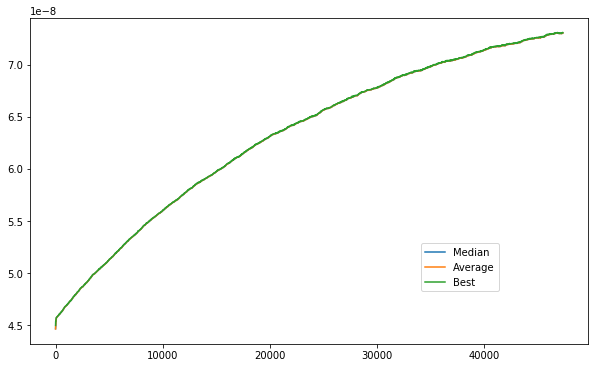

In [46]:
plot_GA(a2, b2, c2, 10)

## Full

In [ ]:
np.random.seed(4)
a2, b2, c2, d2, e2 = GA(citiesnp, 5000, 20, 20, route_fitness, [shift_mutation], 0.1,
                    roulette_selection2, cross_fun=mod_two_point_crossover2, max_no_change = 100, verbose = True)

In [ ]:
1/c2[-1], 1/d2 #tour length of best route

In [ ]:
plot_GA(a2, b2, c2, 10)

In [35]:
np.random.seed(4)
a2, b2, c2, d2, e2 = GA(citiesnp, np.inf, 50, 20, route_fitness, [shift_mutation], 0.1,
                    roulette_selection2, cross_fun=mod_two_point_crossover2, max_no_change = 500, verbose = True)

Iter 0, Sel 0.008945, Cross 0.344709, Rep 0.002365, Mut 0.031915, Ev 0.884632, Up 0.000998, Tot 1.273564, Best 446001709.1153139
Iter 10, Sel 0.008976, Cross 0.335103, Rep 0.002994, Mut 0.026927, Ev 0.877651, Up 0.0, Tot 1.2516509999999998, Best 445814555.21421146
Iter 20, Sel 0.008976, Cross 0.327127, Rep 0.002992, Mut 0.026929, Ev 0.912557, Up 0.000997, Tot 1.2795779999999999, Best 445248310.28177744
Iter 30, Sel 0.008978, Cross 0.312165, Rep 0.002993, Mut 0.027926, Ev 0.969404, Up 0.0, Tot 1.321466, Best 445082946.29625255
Iter 40, Sel 0.010971, Cross 0.303188, Rep 0.002994, Mut 0.027926, Ev 0.913555, Up 0.0, Tot 1.258634, Best 444646695.09562075
Iter 50, Sel 0.008975, Cross 0.315159, Rep 0.001995, Mut 0.027925, Ev 0.852725, Up 0.0, Tot 1.206779, Best 444376113.7361236
Iter 60, Sel 0.008976, Cross 0.319147, Rep 0.002993, Mut 0.030918, Ev 0.91954, Up 0.0, Tot 1.281574, Best 444355498.62290645
Iter 70, Sel 0.012968, Cross 0.376992, Rep 0.002992, Mut 0.029923, Ev 1.953771, Up 0.000997,

KeyboardInterrupt: 

In [ ]:
1/c2[-1], 1/d2 #tour length of best route

In [ ]:
plot_GA(a2, b2, c2, 10)

In [ ]:
np.random.seed(4)
a3, b3, c3, d3, e3 = GA(citiesnp, np.inf, 100, 60, route_fitness, [shift_mutation], 0.1,
                    roulette_selection2, cross_fun=mod_two_point_crossover2, max_no_change = 500, verbose = True)

In [ ]:
1/c3[-1] #tour length of best route

In [ ]:
plot_GA(a3, b3, c3, 10)

In [ ]:
np.random.seed(4)
a2, b2, c2, d2 = GA(citiesnp, 2000, 20, 10, route_fitness, reverse_mutation, 0.1,
                    roulette_selection2, two_point_crossover2, verbose = True)

In [ ]:
1/c2[-1] #tour length of best route

In [ ]:
plot_GA(a2, b2, c2, 10)

In [ ]:
np.random.seed(4)
a3, b3, c3, d3 = GA(citiesnp, 2000, 50, 30, route_fitness, reverse_mutation, 0.1,
                    roulette_selection2, two_point_crossover2, verbose = True)

In [ ]:
1/c3[-1] #tour length of best route

In [ ]:
plot_GA(a3, b3, c3, 10)

## Performance testing

In [ ]:
pop = pop_gen(len(citiesnp), 10)

In [ ]:
scores = pop_eval(citiesnp, pop, route_fitness)

In [ ]:
scores

In [ ]:
timeit.timeit('roulette_selection2(pop, scores, 10)', number=1000, globals=globals())

In [ ]:
timeit.timeit('roulette_selection(pop, scores, 10)', number=1000, globals=globals())

In [ ]:
parents1 = roulette_selection(pop, scores, 10)

In [ ]:
parents2 = roulette_selection2(pop, scores, 10)

In [ ]:
two_point_crossover(parents1)

In [ ]:
two_point_crossover2(parents2)

In [ ]:
mod_two_point_crossover2(parents2)

In [ ]:
two_point_crossover3(parents2)

In [ ]:
timeit.timeit('two_point_crossover(parents1)', number=100, globals=globals())

In [ ]:
timeit.timeit('two_point_crossover2(parents2)', number=100, globals=globals())

In [ ]:
timeit.timeit('mod_two_point_crossover2(parents2)', number=100, globals=globals())

In [ ]:
timeit.timeit('two_point_crossover3(parents2)', number=100, globals=globals())